**Chapter 13 – Loading and Preprocessing Data with TensorFlow**

_This notebook contains all the sample code and solutions to the exercises in chapter 13._

<table align="left">
  <td>
    <a href="https://colab.research.google.com/github/ageron/handson-ml2/blob/master/13_loading_and_preprocessing_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>
  </td>
  <td>
    <a target="_blank" href="https://kaggle.com/kernels/welcome?src=https://github.com/ageron/handson-ml2/blob/master/13_loading_and_preprocessing_data.ipynb"><img src="https://kaggle.com/static/images/open-in-kaggle.svg" /></a>
  </td>
</table>

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0.

In [ ]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

if IS_COLAB or IS_KAGGLE:
    %pip install -q -U tfx==0.21.2
    print("You can safely ignore the package incompatibility errors.")

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "data"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Intro

So far we have used only datasets that fit in memory, but Deep Learning
systems are often trained on very large datasets that will not fit in RAM.
Ingesting a large dataset and preprocessing it efficiently can be tricky to
implement with other Deep Learning libraries, but TensorFlow makes it
easy thanks to the Data API: you just create a dataset object, and tell it
where to get the data and how to transform it. TensorFlow takes care of all
the implementation details, such as multithreading, queuing, batching, and
prefetching. Moreover, the Data API works seamlessly with tf.keras!

Off the shelf, the Data API can read from text files (such as CSV files),
binary files with fixed-size records, and binary files that use TensorFlow’s
TFRecord format, which supports records of varying sizes. TFRecord is a
flexible and efficient binary format based on Protocol Buffers (an open
source binary format). The Data API also has support for reading from SQL
databases. Moreover, many open source extensions are available to read
from all sorts of data sources, such as Google’s BigQuery service.

Reading huge datasets efficiently is not the only difficulty: the data also
needs to be preprocessed, usually normalized. Moreover, it is not always
composed strictly of convenient numerical fields: there may be text
features, categorical features, and so on. These need to be encoded, for
example using one-hot encoding, bag-of-words encoding, or embeddings
(as we will see, an embedding is a trainable dense vector that represents a
category or token). One option to handle all this preprocessing is to write
your own custom preprocessing layers. Another is to use the standard
preprocessing layers provided by Keras.
In this chapter, we will cover the Data API, the TFRecord format, and how
to create custom preprocessing layers and use the standard Keras ones. We
will also take a quick look at a few related projects from TensorFlow’s
ecosystem:

TF Transform (tf.Transform)
- Makes it possible to write a single preprocessing function that can be
run in batch mode on your full training set, before training (to speed it
up), and then exported to a TF Function and incorporated into your
trained model so that once it is deployed in production it can take care
of preprocessing new instances on the fly.

TF Datasets (TFDS)
- Provides a convenient function to download many common datasets of
all kinds, including large ones like ImageNet, as well as convenient
dataset objects to manipulate them using the Data API.


So let’s get started!

# The Data API

The whole Data API revolves around the concept of a dataset: as you might
suspect, this represents a sequence of data items. Usually you will use
datasets that gradually read data from disk, but for simplicity let’s create a
dataset entirely in RAM using
tf.data.Dataset.from_tensor_slices():

In [ ]:
X = tf.range(10)
dataset = tf.data.Dataset.from_tensor_slices(X)
dataset

<TensorSliceDataset shapes: (), types: tf.int32>

The from_tensor_slices() function takes a tensor and creates a
tf.data.Dataset whose elements are all the slices of X (along the first
dimension), so this dataset contains 10 items: tensors 0, 1, 2, …, 9. In this
case we would have obtained the same dataset if we had used
tf.data.Dataset.range(10).

Equivalently:

In [ ]:
dataset = tf.data.Dataset.range(10)

You can simply iterate over a dataset’s items like this:

In [ ]:
for item in dataset:
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(1, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(3, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)
tf.Tensor(5, shape=(), dtype=int64)
tf.Tensor(6, shape=(), dtype=int64)
tf.Tensor(7, shape=(), dtype=int64)
tf.Tensor(8, shape=(), dtype=int64)
tf.Tensor(9, shape=(), dtype=int64)


## Chaining Transformations

Once you have a dataset, you can apply all sorts of transformations to it by
calling its transformation methods. Each method returns a new dataset, so
you can chain transformations like this (this chain is illustrated in
Figure 13-1):

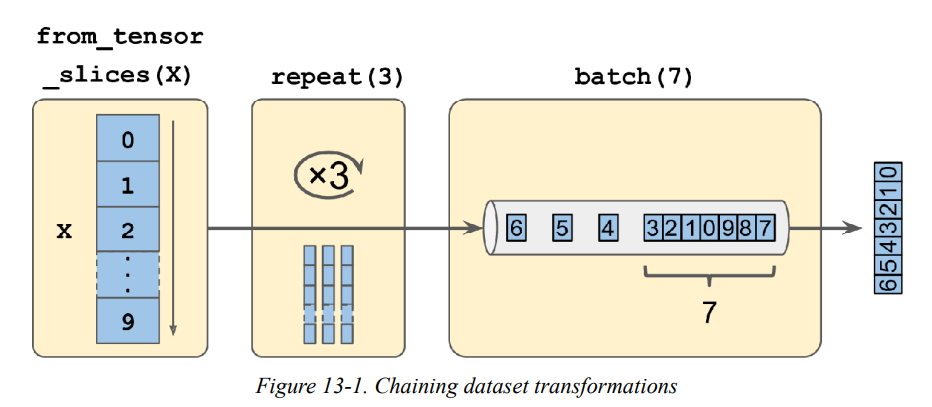

In this example, we first call the repeat() method on the original dataset,
and it returns a new dataset that will repeat the items of the original dataset
three times. Of course, this will not copy all the data in memory three
times! (If you call this method with no arguments, the new dataset will
repeat the source dataset forever, so the code that iterates over the dataset
will have to decide when to stop.) Then we call the batch() method on this
new dataset, and again this creates a new dataset. This one will group the
items of the previous dataset in batches of seven items. Finally, we iterate
over the items of this final dataset. As you can see, the batch() method had
to output a final batch of size two instead of seven, but you can call it with
drop_remainder=True if you want it to drop this final batch so that all
batches have the exact same size.

In [ ]:
dataset = dataset.repeat(3).batch(7)
for item in dataset:
    print(item)

tf.Tensor([0 1 2 3 4 5 6], shape=(7,), dtype=int64)
tf.Tensor([7 8 9 0 1 2 3], shape=(7,), dtype=int64)
tf.Tensor([4 5 6 7 8 9 0], shape=(7,), dtype=int64)
tf.Tensor([1 2 3 4 5 6 7], shape=(7,), dtype=int64)
tf.Tensor([8 9], shape=(2,), dtype=int64)


WARNING

The dataset methods do not modify datasets, they create new ones, so make sure to keep
a reference to these new datasets (e.g., with dataset = ...), or else nothing will
happen.

You can also transform the items by calling the map() method. For
example, this creates a new dataset with all items doubled:

In [ ]:
dataset = dataset.map(lambda x: x * 2)

In [ ]:
for item in dataset:
    print(item)

tf.Tensor([ 0  2  4  6  8 10 12], shape=(7,), dtype=int64)
tf.Tensor([14 16 18  0  2  4  6], shape=(7,), dtype=int64)
tf.Tensor([ 8 10 12 14 16 18  0], shape=(7,), dtype=int64)
tf.Tensor([ 2  4  6  8 10 12 14], shape=(7,), dtype=int64)
tf.Tensor([16 18], shape=(2,), dtype=int64)


This function is the one you will call to apply any preprocessing you want
to your data. Sometimes this will include computations that can be quite
intensive, such as reshaping or rotating an image, so you will usually want
to spawn multiple threads to speed things up: it’s as simple as setting the
num_parallel_calls argument. Note that the function you pass to the
map() method must be convertible to a TF Function (see Chapter 12).

While the map() method applies a transformation to each item, the apply()
method applies a transformation to the dataset as a whole. For example, the
following code applies the unbatch() function to the dataset (this function
is currently experimental, but it will most likely move to the core API in a
future release). Each item in the new dataset will be a single-integer tensor
instead of a batch of seven integers:

In [ ]:
#dataset = dataset.apply(tf.data.experimental.unbatch()) # Now deprecated
dataset = dataset.unbatch()

It is also possible to simply filter the dataset using the filter() method:

In [ ]:
dataset = dataset.filter(lambda x: x < 10)  # keep only items < 10

You will often want to look at just a few items from a dataset. You can use
the take() method for that:

In [ ]:
for item in dataset.take(3):
    print(item)

tf.Tensor(0, shape=(), dtype=int64)
tf.Tensor(2, shape=(), dtype=int64)
tf.Tensor(4, shape=(), dtype=int64)


## Shuffling the Data

As you know, Gradient Descent works best when the instances in the
training set are independent and identically distributed (see Chapter 4). A
simple way to ensure this is to shuffle the instances, using the shuffle()
method. It will create a new dataset that will start by filling up a buffer with
the first items of the source dataset. Then, whenever it is asked for an item,
it will pull one out randomly from the buffer and replace it with a fresh one
from the source dataset, until it has iterated entirely through the source
dataset. At this point it continues to pull out items randomly from the buffer
until it is empty. You must specify the buffer size, and it is important to
make it large enough, or else shuffling will not be very effective. Just don’t
exceed the amount of RAM you have, and even if you have plenty of it,
there’s no need to go beyond the dataset’s size. You can provide a random
seed if you want the same random order every time you run your program.
For example, the following code creates and displays a dataset containing
the integers 0 to 9, repeated 3 times, shuffled using a buffer of size 5 and a
random seed of 42, and batched with a batch size of 7:

In [ ]:
tf.random.set_seed(42)

dataset = tf.data.Dataset.range(10).repeat(3)
dataset = dataset.shuffle(buffer_size=3, seed=42).batch(7)
for item in dataset:
    print(item)

tf.Tensor([1 3 0 4 2 5 6], shape=(7,), dtype=int64)
tf.Tensor([8 7 1 0 3 2 5], shape=(7,), dtype=int64)
tf.Tensor([4 6 9 8 9 7 0], shape=(7,), dtype=int64)
tf.Tensor([3 1 4 5 2 8 7], shape=(7,), dtype=int64)
tf.Tensor([6 9], shape=(2,), dtype=int64)


TIP

If you call repeat() on a shuffled dataset, by default it will generate a new order at
every iteration. This is generally a good idea, but if you prefer to reuse the same order at
each iteration (e.g., for tests or debugging), you can set
reshuffle_each_iteration=False.

For a large dataset that does not fit in memory, this simple shuffling-buffer
approach may not be sufficient, since the buffer will be small compared to
the dataset. One solution is to shuffle the source data itself (for example, on
Linux you can shuffle text files using the shuf command). This will
definitely improve shuffling a lot! Even if the source data is shuffled, you
will usually want to shuffle it some more, or else the same order will be
repeated at each epoch, and the model may end up being biased (e.g., due to
1
some spurious patterns present by chance in the source data’s order). To
shuffle the instances some more, a common approach is to split the source
data into multiple files, then read them in a random order during training.
However, instances located in the same file will still end up close to each
other. To avoid this you can pick multiple files randomly and read them
simultaneously, interleaving their records. Then on top of that you can add a
shuffling buffer using the shuffle() method. If all this sounds like a lot of
work, don’t worry: the Data API makes all this possible in just a few lines
of code. Let’s see how to do this.

## Interleaving lines from multiple files

Let's start by loading and preparing the California housing dataset. We first load it, then split it into a training set, a validation set and a test set, and finally we scale it:

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(
    housing.data, housing.target.reshape(-1, 1), random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(
    X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
scaler.fit(X_train)
X_mean = scaler.mean_
X_std = scaler.scale_

For a very large dataset that does not fit in memory, you will typically want to split it into many files first, then have TensorFlow read these files in parallel. To demonstrate this, let's start by splitting the housing dataset and save it to 20 CSV files:

In [ ]:
def save_to_multiple_csv_files(data, name_prefix, header=None, n_parts=10):
    housing_dir = os.path.join("datasets", "housing")
    os.makedirs(housing_dir, exist_ok=True)
    path_format = os.path.join(housing_dir, "my_{}_{:02d}.csv")

    filepaths = []
    m = len(data)
    for file_idx, row_indices in enumerate(np.array_split(np.arange(m), n_parts)):
        part_csv = path_format.format(name_prefix, file_idx)
        filepaths.append(part_csv)
        with open(part_csv, "wt", encoding="utf-8") as f:
            if header is not None:
                f.write(header)
                f.write("\n")
            for row_idx in row_indices:
                f.write(",".join([repr(col) for col in data[row_idx]]))
                f.write("\n")
    return filepaths

In [ ]:
train_data = np.c_[X_train, y_train]
valid_data = np.c_[X_valid, y_valid]
test_data = np.c_[X_test, y_test]
header_cols = housing.feature_names + ["MedianHouseValue"]
header = ",".join(header_cols)

train_filepaths = save_to_multiple_csv_files(train_data, "train", header, n_parts=20)
valid_filepaths = save_to_multiple_csv_files(valid_data, "valid", header, n_parts=10)
test_filepaths = save_to_multiple_csv_files(test_data, "test", header, n_parts=10)

Okay, now let's take a peek at the first few lines of one of these CSV files:

In [ ]:
import pandas as pd

pd.read_csv(train_filepaths[0]).head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
0,3.5214,15.0,3.049945,1.106548,1447.0,1.605993,37.63,-122.43,1.442
1,5.3275,5.0,6.490060,0.991054,3464.0,3.443340,33.69,-117.39,1.687
2,3.1000,29.0,7.542373,1.591525,1328.0,2.250847,38.44,-122.98,1.621
3,7.1736,12.0,6.289003,0.997442,1054.0,2.695652,33.55,-117.70,2.621
4,2.0549,13.0,5.312457,1.085092,3297.0,2.244384,33.93,-116.93,0.956


Or in text mode:

In [ ]:
with open(train_filepaths[0]) as f:
    for i in range(5):
        print(f.readline(), end="")

MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedianHouseValue
3.5214,15.0,3.0499445061043287,1.106548279689234,1447.0,1.6059933407325193,37.63,-122.43,1.442
5.3275,5.0,6.490059642147117,0.9910536779324056,3464.0,3.4433399602385686,33.69,-117.39,1.687
3.1,29.0,7.5423728813559325,1.5915254237288134,1328.0,2.2508474576271187,38.44,-122.98,1.621
7.1736,12.0,6.289002557544757,0.9974424552429667,1054.0,2.6956521739130435,33.55,-117.7,2.621


In [ ]:
train_filepaths

['datasets/housing/my_train_00.csv',
 'datasets/housing/my_train_01.csv',
 'datasets/housing/my_train_02.csv',
 'datasets/housing/my_train_03.csv',
 'datasets/housing/my_train_04.csv',
 'datasets/housing/my_train_05.csv',
 'datasets/housing/my_train_06.csv',
 'datasets/housing/my_train_07.csv',
 'datasets/housing/my_train_08.csv',
 'datasets/housing/my_train_09.csv',
 'datasets/housing/my_train_10.csv',
 'datasets/housing/my_train_11.csv',
 'datasets/housing/my_train_12.csv',
 'datasets/housing/my_train_13.csv',
 'datasets/housing/my_train_14.csv',
 'datasets/housing/my_train_15.csv',
 'datasets/housing/my_train_16.csv',
 'datasets/housing/my_train_17.csv',
 'datasets/housing/my_train_18.csv',
 'datasets/housing/my_train_19.csv']

By default, the list_files() function returns a dataset that shuffles the
file paths. In general this is a good thing, but you can set shuffle=False if
you do not want that for some reason.

In [ ]:
filepath_dataset = tf.data.Dataset.list_files(train_filepaths, seed=42)

In [ ]:
for filepath in filepath_dataset:
    print(filepath)

tf.Tensor(b'datasets/housing/my_train_15.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_08.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_03.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_01.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_10.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_05.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_19.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_16.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_02.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_09.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_00.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_07.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_12.csv', shape=(), dtype=string)
tf.Tensor(b'datasets/housing/my_train_04.csv', shape=(), dtype=string)
tf.Ten

Next, you can call the interleave() method to read from five files at a
time and interleave their lines (skipping the first line of each file, which is
the header row, using the skip() method):

In [ ]:
n_readers = 5
dataset = filepath_dataset.interleave(
    lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
    cycle_length=n_readers)

The interleave() method will create a dataset that will pull five file paths
from the filepath_dataset, and for each one it will call the function you
gave it (a lambda in this example) to create a new dataset (in this case a
TextLineDataset). To be clear, at this stage there will be seven datasets in
all: the filepath dataset, the interleave dataset, and the five
TextLineDatasets created internally by the interleave dataset. When we
iterate over the interleave dataset, it will cycle through these five
TextLineDatasets, reading one line at a time from each until all datasets
are out of items. Then it will get the next five file paths from the
filepath_dataset and interleave them the same way, and so on until it
runs out of file paths.

TIP

For interleaving to work best, it is preferable to have files of identical length; otherwise
the ends of the longest files will not be interleaved.

By default, interleave() does not use parallelism; it just reads one line at
a time from each file, sequentially. If you want it to actually read files in
parallel, you can set the num_parallel_calls argument to the number of
threads you want (note that the map() method also has this argument). You
can even set it to tf.data.experimental.AUTOTUNE to make TensorFlow
choose the right number of threads dynamically based on the available CPU
(however, this is an experimental feature for now). Let’s look at what the
dataset contains now:

In [ ]:
for line in dataset.take(5):
    print(line.numpy())

b'4.6477,38.0,5.03728813559322,0.911864406779661,745.0,2.5254237288135593,32.64,-117.07,1.504'
b'8.72,44.0,6.163179916317992,1.0460251046025104,668.0,2.794979079497908,34.2,-118.18,4.159'
b'3.8456,35.0,5.461346633416459,0.9576059850374065,1154.0,2.8778054862842892,37.96,-122.05,1.598'
b'3.3456,37.0,4.514084507042254,0.9084507042253521,458.0,3.2253521126760565,36.67,-121.7,2.526'
b'3.6875,44.0,4.524475524475524,0.993006993006993,457.0,3.195804195804196,34.04,-118.15,1.625'


These are the first rows (ignoring the header row) of five CSV files, chosen
randomly. Looks good! But as you can see, these are just byte strings; we
need to parse them and scale the data.

In [ ]:
record_defaults=[0, np.nan, tf.constant(np.nan, dtype=tf.float64), "Hello", tf.constant([])]
parsed_fields = tf.io.decode_csv('1,2,3,4,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=1>,
 <tf.Tensor: shape=(), dtype=float32, numpy=2.0>,
 <tf.Tensor: shape=(), dtype=float64, numpy=3.0>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'4'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

Notice that all missing fields are replaced with their default value, when provided:

In [ ]:
parsed_fields = tf.io.decode_csv(',,,,5', record_defaults)
parsed_fields

[<tf.Tensor: shape=(), dtype=int32, numpy=0>,
 <tf.Tensor: shape=(), dtype=float32, numpy=nan>,
 <tf.Tensor: shape=(), dtype=float64, numpy=nan>,
 <tf.Tensor: shape=(), dtype=string, numpy=b'Hello'>,
 <tf.Tensor: shape=(), dtype=float32, numpy=5.0>]

The 5th field is compulsory (since we provided `tf.constant([])` as the "default value"), so we get an exception if we do not provide it:

In [ ]:
try:
    parsed_fields = tf.io.decode_csv(',,,,', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Field 4 is required but missing in record 0! [Op:DecodeCSV]


The number of fields should match exactly the number of fields in the `record_defaults`:

In [ ]:
try:
    parsed_fields = tf.io.decode_csv('1,2,3,4,5,6,7', record_defaults)
except tf.errors.InvalidArgumentError as ex:
    print(ex)

Expect 5 fields but have 7 in record 0 [Op:DecodeCSV]


Let’s implement a small function that will perform this preprocessing:

In [ ]:
n_inputs = 8 # X_train.shape[-1]

@tf.function
def preprocess(line):
    defs = [0.] * n_inputs + [tf.constant([], dtype=tf.float32)]
    fields = tf.io.decode_csv(line, record_defaults=defs)
    x = tf.stack(fields[:-1])
    y = tf.stack(fields[-1:])
    return (x - X_mean) / X_std, y

Let’s walk through this code:

- First, the code assumes that we have precomputed the mean and
standard deviation of each feature in the training set. X_mean and
X_std are just 1D tensors (or NumPy arrays) containing eight
floats, one per input feature.
- The preprocess() function takes one CSV line and starts by
parsing it. For this it uses the tf.io.decode_csv() function,
which takes two arguments: the first is the line to parse, and the
second is an array containing the default value for each column in
the CSV file. This array tells TensorFlow not only the default value
for each column, but also the number of columns and their types.
In this example, we tell it that all feature columns are floats and
that missing values should default to 0, but we provide an empty
array of type tf.float32 as the default value for the last column
(the target): the array tells TensorFlow that this column contains
floats, but that there is no default value, so it will raise an
exception if it encounters a missing value.
- The decode_csv() function returns a list of scalar tensors (one per
column), but we need to return 1D tensor arrays. So we call
tf.stack() on all tensors except for the last one (the target): this
will stack these tensors into a 1D array. We then do the same for
the target value (this makes it a 1D tensor array with a single value,
rather than a scalar tensor).
- Finally, we scale the input features by subtracting the feature
means and then dividing by the feature standard deviations, and we
return a tuple containing the scaled features and the target.

Let's test this preprocessing function:

In [ ]:
preprocess(b'4.2083,44.0,5.3232,0.9171,846.0,2.3370,37.47,-122.2,2.782')

(<tf.Tensor: shape=(8,), dtype=float32, numpy=
 array([ 0.16579157,  1.216324  , -0.05204565, -0.39215982, -0.5277444 ,
        -0.2633488 ,  0.8543046 , -1.3072058 ], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([2.782], dtype=float32)>)

Looks good! We can now apply the function to the dataset.

## Putting Everything Together

To make the code reusable, let’s put together everything we have discussed
so far into a small helper function: it will create and return a dataset that
will efficiently load California housing data from multiple CSV files,
preprocess it, shuffle it, optionally repeat it, and batch it (see Figure 13-2):


In [ ]:
def csv_reader_dataset(filepaths, repeat=1, n_readers=5,
                       n_read_threads=None, shuffle_buffer_size=10000,
                       n_parse_threads=5, batch_size=32):
    dataset = tf.data.Dataset.list_files(filepaths).repeat(repeat)
    dataset = dataset.interleave(
        lambda filepath: tf.data.TextLineDataset(filepath).skip(1),
        cycle_length=n_readers, num_parallel_calls=n_read_threads)
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

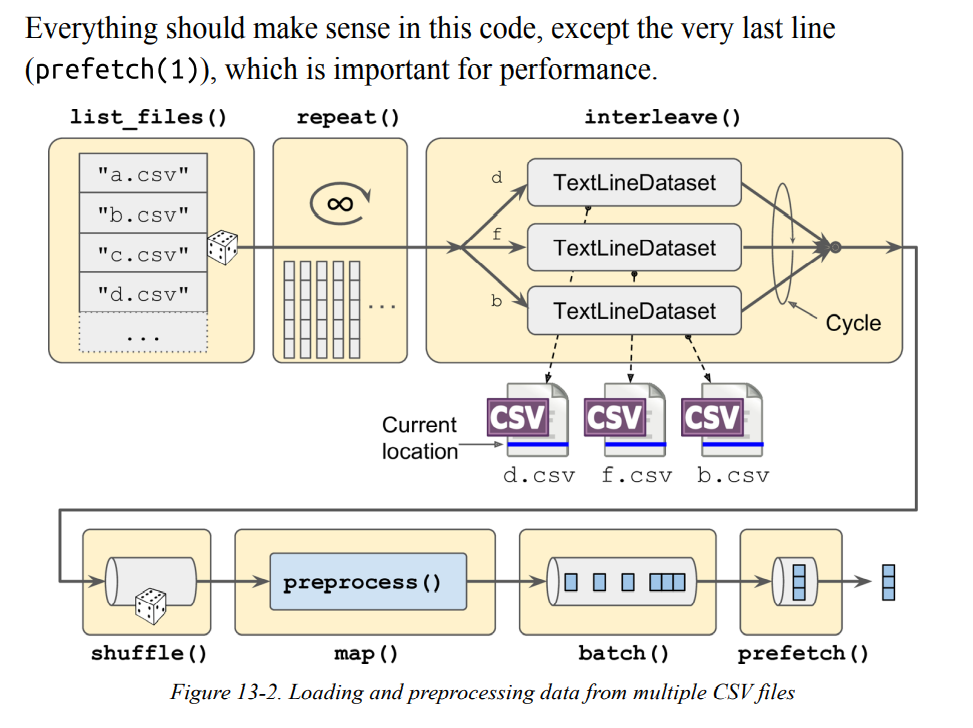

## Prefetching

By calling prefetch(1) at the end, we are creating a dataset that will do its
best to always be one batch ahead. In other words, while our training
algorithm is working on one batch, the dataset will already be working in
parallel on getting the next batch ready (e.g., reading the data from disk and
preprocessing it). This can improve performance dramatically, as is
illustrated in Figure 13-3. If we also ensure that loading and preprocessing
are multithreaded (by setting num_parallel_calls when calling
interleave() and map()), we can exploit multiple cores on the CPU and
hopefully make preparing one batch of data shorter than running a training
step on the GPU: this way the GPU will be almost 100% utilized (except
for the data transfer time from the CPU to the GPU ), and training will run
much faster.

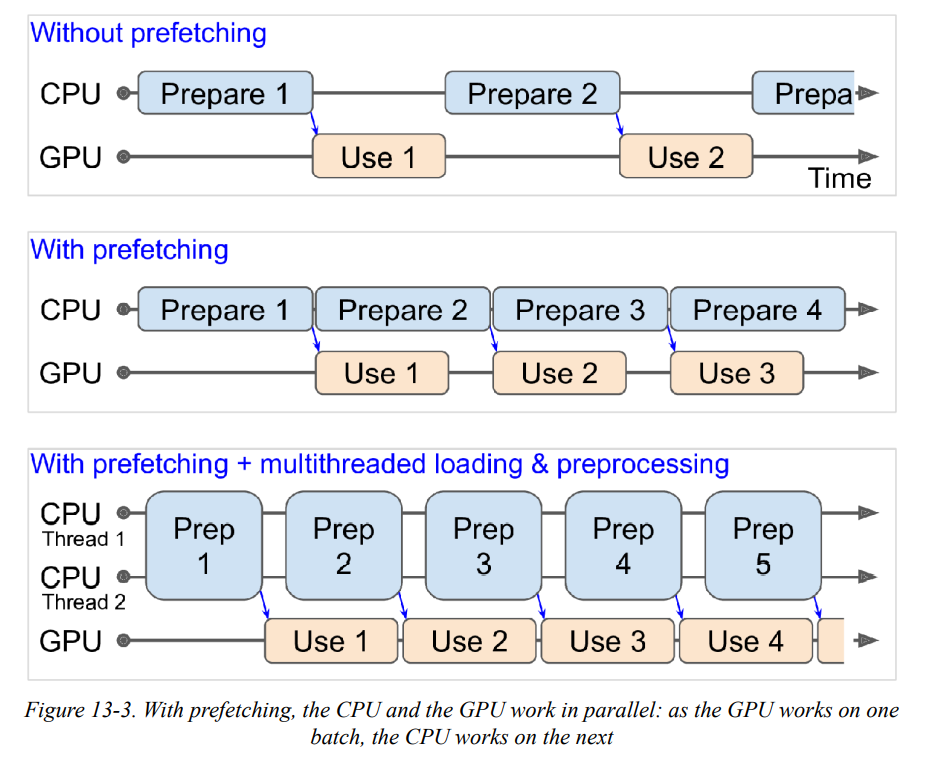

TIP

If you plan to purchase a GPU card, its processing power and its memory size are of
course very important (in particular, a large amount of RAM is crucial for computer
vision). Just as important to get good performance is its memory bandwidth; this is the
number of gigabytes of data it can get into or out of its RAM per second.

If the dataset is small enough to fit in memory, you can significantly speed
up training by using the dataset’s cache() method to cache its content to
RAM. You should generally do this after loading and preprocessing the
data, but before shuffling, repeating, batching, and prefetching. This way,
each instance will only be read and preprocessed once (instead of once per
epoch), but the data will still be shuffled differently at each epoch, and the
next batch will still be prepared in advance.

You now know how to build efficient input pipelines to load and preprocess
data from multiple text files. We have discussed the most common dataset
methods, but there are a few more you may want to look at:
concatenate(), zip(), window(), reduce(), shard(), flat_map(), and
padded_batch(). There are also a couple more class methods:
from_generator() and from_tensors(), which create a new dataset from
a Python generator or a list of tensors, respectively. Please check the API
documentation for more details. Also note that there are experimental
features available in tf.data.experimental, many of which will likely
make it to the core API in future releases (e.g., check out the CsvDataset
class, as well as the make_csv_dataset() method, which takes care of
inferring the type of each column).

## Using the Dataset with tf.keras

In [ ]:
tf.random.set_seed(42)

train_set = csv_reader_dataset(train_filepaths, batch_size=3)
for X_batch, y_batch in train_set.take(2):
    print("X =", X_batch)
    print("y =", y_batch)
    print()

X = tf.Tensor(
[[ 0.5804519  -0.20762321  0.05616303 -0.15191229  0.01343246  0.00604472
   1.2525111  -1.3671792 ]
 [ 5.818099    1.8491895   1.1784915   0.28173092 -1.2496178  -0.3571987
   0.7231292  -1.0023477 ]
 [-0.9253566   0.5834586  -0.7807257  -0.28213993 -0.36530012  0.27389365
  -0.76194876  0.72684526]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[1.752]
 [1.313]
 [1.535]], shape=(3, 1), dtype=float32)

X = tf.Tensor(
[[-0.8324941   0.6625668  -0.20741376 -0.18699841 -0.14536144  0.09635526
   0.9807942  -0.67250353]
 [-0.62183803  0.5834586  -0.19862501 -0.3500319  -1.1437552  -0.3363751
   1.107282   -0.8674123 ]
 [ 0.8683102   0.02970133  0.3427381  -0.29872298  0.7124906   0.28026953
  -0.72915536  0.86178064]], shape=(3, 8), dtype=float32)
y = tf.Tensor(
[[0.919]
 [1.028]
 [2.182]], shape=(3, 1), dtype=float32)



Now we can use the csv_reader_dataset() function to create a dataset
for the training set. Note that we do not need to repeat it, as this will be
taken care of by tf.keras. We also create datasets for the validation set and
the test set

In [ ]:
train_set = csv_reader_dataset(train_filepaths, repeat=None)
valid_set = csv_reader_dataset(valid_filepaths)
test_set = csv_reader_dataset(test_filepaths)

And now we can simply build and train a Keras model using these
datasets. All we need to do is pass the training and validation datasets to
the fit() method, instead of X_train, y_train, X_valid, and y_valid:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1),
])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(learning_rate=1e-3))

In [ ]:
batch_size = 32
model.fit(train_set, steps_per_epoch=len(X_train) // batch_size, epochs=10,
          validation_data=valid_set)

Epoch 1/10
362/362 [==============================] - 1s 3ms/step - loss: 2.0914 - val_loss: 21.5124
Epoch 2/10
362/362 [==============================] - 0s 1ms/step - loss: 0.8428 - val_loss: 0.6648
Epoch 3/10
362/362 [==============================] - 0s 1ms/step - loss: 0.6329 - val_loss: 0.6196
Epoch 4/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5922 - val_loss: 0.5669
Epoch 5/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5622 - val_loss: 0.5402
Epoch 6/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5698 - val_loss: 0.5209
Epoch 7/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5195 - val_loss: 0.6130
Epoch 8/10
362/362 [==============================] - 0s 1ms/step - loss: 0.5155 - val_loss: 0.4818
Epoch 9/10
362/362 [==============================] - 0s 1ms/step - loss: 0.4965 - val_loss: 0.4904
Epoch 10/10
362/362 [==============================] - 0s 1ms/step - loss: 0.4925 - val_loss: 0.458

Similarly, we can pass a dataset to the evaluate() and predict()
methods:

In [ ]:
model.evaluate(test_set, steps=len(X_test) // batch_size)

161/161 [==============================] - 0s 589us/step - loss: 0.4788


0.4787752032279968

In [ ]:
new_set = test_set.map(lambda X, y: X) # we could instead just pass test_set, Keras would ignore the labels
X_new = X_test
model.predict(new_set, steps=len(X_new) // batch_size)

array([[2.3576407],
       [2.255291 ],
       [1.4437605],
       ...,
       [0.5654393],
       [3.9442453],
       [1.0232248]], dtype=float32)

Unlike the other sets, the new_set will usually not contain labels (if it does,
Keras will ignore them). Note that in all these cases, you can still use
NumPy arrays instead of datasets if you want (but of course they need to
have been loaded and preprocessed first).
If you want to build your own custom training loop (as in Chapter 12), you
can just iterate over the training set, very naturally:

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

n_epochs = 5
batch_size = 32
n_steps_per_epoch = len(X_train) // batch_size
total_steps = n_epochs * n_steps_per_epoch
global_step = 0
for X_batch, y_batch in train_set.take(total_steps):
    global_step += 1
    print("\rGlobal step {}/{}".format(global_step, total_steps), end="")
    with tf.GradientTape() as tape:
        y_pred = model(X_batch)
        main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
        loss = tf.add_n([main_loss] + model.losses)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

Global step 1810/1810

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In fact, it is even possible to create a TF Function (see Chapter 12) that
performs the whole training loop:

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    for X_batch, y_batch in train_set:
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = keras.losses.mean_squared_error

@tf.function
def train(model, n_epochs, batch_size=32,
          n_readers=5, n_read_threads=5, shuffle_buffer_size=10000, n_parse_threads=5):
    train_set = csv_reader_dataset(train_filepaths, repeat=n_epochs, n_readers=n_readers,
                       n_read_threads=n_read_threads, shuffle_buffer_size=shuffle_buffer_size,
                       n_parse_threads=n_parse_threads, batch_size=batch_size)
    n_steps_per_epoch = len(X_train) // batch_size
    total_steps = n_epochs * n_steps_per_epoch
    global_step = 0
    for X_batch, y_batch in train_set.take(total_steps):
        global_step += 1
        if tf.equal(global_step % 100, 0):
            tf.print("\rGlobal step", global_step, "/", total_steps)
        with tf.GradientTape() as tape:
            y_pred = model(X_batch)
            main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
            loss = tf.add_n([main_loss] + model.losses)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

train(model, 5)

Global step 100 / 1810
Global step 200 / 1810
Global step 300 / 1810
Global step 400 / 1810
Global step 500 / 1810
Global step 600 / 1810
Global step 700 / 1810
Global step 800 / 1810
Global step 900 / 1810
Global step 1000 / 1810
Global step 1100 / 1810
Global step 1200 / 1810
Global step 1300 / 1810
Global step 1400 / 1810
Global step 1500 / 1810
Global step 1600 / 1810
Global step 1700 / 1810
Global step 1800 / 1810


Here is a short description of each method in the `Dataset` class:

In [ ]:
for m in dir(tf.data.Dataset):
    if not (m.startswith("_") or m.endswith("_")):
        func = getattr(tf.data.Dataset, m)
        if hasattr(func, "__doc__"):
            print("● {:21s}{}".format(m + "()", func.__doc__.split("\n")[0]))

● apply()              Applies a transformation function to this dataset.
● as_numpy_iterator()  Returns an iterator which converts all elements of the dataset to numpy.
● batch()              Combines consecutive elements of this dataset into batches.
● cache()              Caches the elements in this dataset.
● cardinality()        Returns the cardinality of the dataset, if known.
● concatenate()        Creates a `Dataset` by concatenating the given dataset with this dataset.
● element_spec()       The type specification of an element of this dataset.
● enumerate()          Enumerates the elements of this dataset.
● filter()             Filters this dataset according to `predicate`.
● flat_map()           Maps `map_func` across this dataset and flattens the result.
● from_generator()     Creates a `Dataset` whose elements are generated by `generator`. (deprecated arguments)
● from_tensor_slices() Creates a `Dataset` whose elements are slices of the given tensors.
● from_tensors()    

Congratulations, you now know how to build powerful input pipelines
using the Data API! However, so far we have used CSV files, which are
common, simple, and convenient but not really efficient, and do not support
large or complex data structures (such as images or audio) very well. So
let’s see how to use TFRecords instead.

# The `TFRecord` binary format

The TFRecord format is TensorFlow’s preferred format for storing large
amounts of data and reading it efficiently. It is a very simple binary format
that just contains a sequence of binary records of varying sizes (each record
is comprised of a length, a CRC checksum to check that the length was not
corrupted, then the actual data, and finally a CRC checksum for the data).
You can easily create a TFRecord file using the tf.io.TFRecordWriter
class:

In [ ]:
with tf.io.TFRecordWriter("my_data.tfrecord") as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

And you can read it using a `tf.data.TFRecordDataset`:

In [ ]:
filepaths = ["my_data.tfrecord"]
dataset = tf.data.TFRecordDataset(filepaths)
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


You can read multiple TFRecord files with just one `TFRecordDataset`. By default it will read them one at a time, but if you set `num_parallel_reads=3`, it will read 3 at a time in parallel and interleave their records:

In [ ]:
filepaths = ["my_test_{}.tfrecord".format(i) for i in range(5)]
for i, filepath in enumerate(filepaths):
    with tf.io.TFRecordWriter(filepath) as f:
        for j in range(3):
            f.write("File {} record {}".format(i, j).encode("utf-8"))

dataset = tf.data.TFRecordDataset(filepaths, num_parallel_reads=3)
for item in dataset:
    print(item)

tf.Tensor(b'File 0 record 0', shape=(), dtype=string)
tf.Tensor(b'File 1 record 0', shape=(), dtype=string)
tf.Tensor(b'File 2 record 0', shape=(), dtype=string)
tf.Tensor(b'File 0 record 1', shape=(), dtype=string)
tf.Tensor(b'File 1 record 1', shape=(), dtype=string)
tf.Tensor(b'File 2 record 1', shape=(), dtype=string)
tf.Tensor(b'File 0 record 2', shape=(), dtype=string)
tf.Tensor(b'File 1 record 2', shape=(), dtype=string)
tf.Tensor(b'File 2 record 2', shape=(), dtype=string)
tf.Tensor(b'File 3 record 0', shape=(), dtype=string)
tf.Tensor(b'File 4 record 0', shape=(), dtype=string)
tf.Tensor(b'File 3 record 1', shape=(), dtype=string)
tf.Tensor(b'File 4 record 1', shape=(), dtype=string)
tf.Tensor(b'File 3 record 2', shape=(), dtype=string)
tf.Tensor(b'File 4 record 2', shape=(), dtype=string)


## Compressed TFRecord files

It can sometimes be useful to compress your TFRecord files, especially if
they need to be loaded via a network connection. You can create a
compressed TFRecord file by setting the options argument:

In [ ]:
options = tf.io.TFRecordOptions(compression_type="GZIP")
with tf.io.TFRecordWriter("my_compressed.tfrecord", options) as f:
    f.write(b"This is the first record")
    f.write(b"And this is the second record")

When reading a compressed TFRecord file, you need to specify the
compression type:

In [ ]:
dataset = tf.data.TFRecordDataset(["my_compressed.tfrecord"],
                                  compression_type="GZIP")
for item in dataset:
    print(item)

tf.Tensor(b'This is the first record', shape=(), dtype=string)
tf.Tensor(b'And this is the second record', shape=(), dtype=string)


## A Brief Intro to Protocol Buffers

For this section you need to [install protobuf](https://developers.google.com/protocol-buffers/docs/downloads). In general you will not have to do so when using TensorFlow, as it comes with functions to create and parse protocol buffers of type `tf.train.Example`, which are generally sufficient. However, in this section we will learn about protocol buffers by creating our own simple protobuf definition, so we need the protobuf compiler (`protoc`): we will use it to compile the protobuf definition to a Python module that we can then use in our code.

First let's write a simple protobuf definition:

In [ ]:
%%writefile person.proto
syntax = "proto3";
message Person {
  string name = 1;
  int32 id = 2;
  repeated string email = 3;
}

Overwriting person.proto


This definition says we are using version 3 of the protobuf format, and it
specifies that each Person object may (optionally) have a name of type
string, an id of type int32, and zero or more email fields, each of type
string. The numbers 1, 2, and 3 are the field identifiers: they will be used
in each record’s binary representation. Once you have a definition in a
.proto file, you can compile it. This requires protoc, the protobuf compiler,
to generate access classes in Python (or some other language). Note that the
protobuf definitions we will use have already been compiled for you, and
their Python classes are part of TensorFlow, so you will not need to use
protoc. All you need to know is how to use protobuf access classes in
Python. To illustrate the basics, let’s look at a simple example that uses the
access classes generated for the Person protobuf (the code is explained in
the comments):

And let's compile it (the `--descriptor_set_out` and `--include_imports` options are only required for the `tf.io.decode_proto()` example below):

In [ ]:
!protoc person.proto --python_out=. --descriptor_set_out=person.desc --include_imports

In [ ]:
!ls person*

person.desc   person.proto  person_pb2.py


In [ ]:
from person_pb2 import Person

person = Person(name="Al", id=123, email=["a@b.com"])  # create a Person
print(person)  # display the Person

name: "Al"
id: 123
email: "a@b.com"



In [ ]:
person.name  # read a field

'Al'

In [ ]:
person.name = "Alice"  # modify a field

In [ ]:
person.email[0]  # repeated fields can be accessed like arrays

'a@b.com'

In [ ]:
person.email.append("c@d.com")  # add an email address

In [ ]:
s = person.SerializeToString()  # serialize to a byte string
s

b'\n\x05Alice\x10{\x1a\x07a@b.com\x1a\x07c@d.com'

In [ ]:
person2 = Person()  # create a new Person
person2.ParseFromString(s)  # parse the byte string (27 bytes)

27

In [ ]:
person == person2  # now they are equal

True

In short, we import the Person class generated by protoc, we create an
instance and play with it, visualizing it and reading and writing some fields,
then we serialize it using the SerializeToString() method. This is the
binary data that is ready to be saved or transmitted over the network. When
reading or receiving this binary data, we can parse it using the
ParseFromString() method, and we get a copy of the object that was
serialized.

We could save the serialized Person object to a TFRecord file, then we
could load and parse it: everything would work fine. However,
SerializeToString() and ParseFromString() are not TensorFlow
operations (and neither are the other operations in this code), so they cannot
be included in a TensorFlow Function (except by wrapping them in a
tf.py_function() operation, which would make the code slower and less
portable, as we saw in Chapter 12). Fortunately, TensorFlow does include
special protobuf definitions for which it provides parsing operations.

### Custom protobuf

In rare cases, you may want to parse a custom protobuf (like the one we just created) in TensorFlow. For this you can use the `tf.io.decode_proto()` function:

In [ ]:
person_tf = tf.io.decode_proto(
    bytes=s,
    message_type="Person",
    field_names=["name", "id", "email"],
    output_types=[tf.string, tf.int32, tf.string],
    descriptor_source="person.desc")

person_tf.values

[<tf.Tensor: shape=(1,), dtype=string, numpy=array([b'Alice'], dtype=object)>,
 <tf.Tensor: shape=(1,), dtype=int32, numpy=array([123], dtype=int32)>,
 <tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>]

For more details, see the [`tf.io.decode_proto()`](https://www.tensorflow.org/api_docs/python/tf/io/decode_proto) documentation.

### TensorFlow Protobufs

The main protobuf typically used in a TFRecord file is the Example
protobuf, which represents one instance in a dataset. It contains a list of
named features, where each feature can either be a list of byte strings, a list
of floats, or a list of integers. Here is the protobuf definition:

Here is the definition of the tf.train.Example protobuf:

```proto
syntax = "proto3";

message BytesList { repeated bytes value = 1; }
message FloatList { repeated float value = 1 [packed = true]; }
message Int64List { repeated int64 value = 1 [packed = true]; }
message Feature {
    oneof kind {
        BytesList bytes_list = 1;
        FloatList float_list = 2;
        Int64List int64_list = 3;
    }
};
message Features { map<string, Feature> feature = 1; };
message Example { Features features = 1; };
```

The definitions of BytesList, FloatList, and Int64List are
straightforward enough. Note that [packed = true] is used for repeated
numerical fields, for a more efficient encoding. A Feature contains either a
BytesList, a FloatList, or an Int64List. A Features (with an s)
contains a dictionary that maps a feature name to the corresponding feature
value. And finally, an Example contains only a Features object. Here is
how you could create a tf.train.Example representing the same person as
earlier and write it to a TFRecord file:

**Warning**: in TensorFlow 2.0 and 2.1, there was a bug preventing `from tensorflow.train import X` so we work around it by writing `X = tf.train.X`. See https://github.com/tensorflow/tensorflow/issues/33289 for more details.

In [ ]:
#from tensorflow.train import BytesList, FloatList, Int64List
#from tensorflow.train import Feature, Features, Example
BytesList = tf.train.BytesList
FloatList = tf.train.FloatList
Int64List = tf.train.Int64List
Feature = tf.train.Feature
Features = tf.train.Features
Example = tf.train.Example

person_example = Example(
    features=Features(
        feature={
            "name": Feature(bytes_list=BytesList(value=[b"Alice"])),
            "id": Feature(int64_list=Int64List(value=[123])),
            "emails": Feature(bytes_list=BytesList(value=[b"a@b.com", b"c@d.com"]))
        }))

# The code is a bit verbose and repetitive, but it’s rather straightforward (and you could easily wrap it inside a small helper function). 
# Now that we have an Example protobuf, we can serialize it by calling its SerializeToString() method, 
# then write the resulting data to a TFRecord file:

with tf.io.TFRecordWriter("my_contacts.tfrecord") as f:
    f.write(person_example.SerializeToString())

Normally you would write much more than one Example! Typically, you
would create a conversion script that reads from your current format (say,
8
CSV files), creates an Example protobuf for each instance, serializes them,
and saves them to several TFRecord files, ideally shuffling them in the
process. This requires a bit of work, so once again make sure it is really
necessary (perhaps your pipeline works fine with CSV files).
Now that we have a nice TFRecord file containing a serialized Example,
let’s try to load it

### Loading and Parsing Examples

To load the serialized Example protobufs, we will use a
tf.data.TFRecordDataset once again, and we will parse each Example
using tf.io.parse_single_example(). This is a TensorFlow operation,
so it can be included in a TF Function. It requires at least two arguments: a
string scalar tensor containing the serialized data, and a description of each
feature. The description is a dictionary that maps each feature name to
either a tf.io.FixedLenFeature descriptor indicating the feature’s shape,
type, and default value, or a tf.io.VarLenFeature descriptor indicating
only the type (if the length of the feature’s list may vary, such as for the
"emails" feature).

The following code defines a description dictionary, then it iterates over the
TFRecordDataset and parses the serialized Example protobuf this dataset
contains:

In [ ]:
feature_description = {
    "name": tf.io.FixedLenFeature([], tf.string, default_value=""),
    "id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "emails": tf.io.VarLenFeature(tf.string),
}
for serialized_example in tf.data.TFRecordDataset(["my_contacts.tfrecord"]):
    parsed_example = tf.io.parse_single_example(serialized_example,
                                                feature_description)

The fixed-length features are parsed as regular tensors, but the variablelength features are parsed as sparse tensors. You can convert a sparse tensor
to a dense tensor using tf.sparse.to_dense(), but in this case it is
simpler to just access its values:

In [ ]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd640710890>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [ ]:
parsed_example

{'emails': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd640710890>,
 'id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'name': <tf.Tensor: shape=(), dtype=string, numpy=b'Alice'>}

In [ ]:
parsed_example["emails"].values[0]

<tf.Tensor: shape=(), dtype=string, numpy=b'a@b.com'>

In [ ]:
tf.sparse.to_dense(parsed_example["emails"], default_value=b"")

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

In [ ]:
parsed_example["emails"].values

<tf.Tensor: shape=(2,), dtype=string, numpy=array([b'a@b.com', b'c@d.com'], dtype=object)>

A BytesList can contain any binary data you want, including any
serialized object. For example, you can use tf.io.encode_jpeg() to
encode an image using the JPEG format and put this binary data in a
BytesList. Later, when your code reads the TFRecord, it will start by
parsing the Example, then it will need to call tf.io.decode_jpeg() to
parse the data and get the original image (or you can use
tf.io.decode_image(), which can decode any BMP, GIF, JPEG, or PNG
image). You can also store any tensor you want in a BytesList by
serializing the tensor using tf.io.serialize_tensor() then putting the
resulting byte string in a BytesList feature. Later, when you parse the
TFRecord, you can parse this data using tf.io.parse_tensor().
Instead of parsing examples one by one using
tf.io.parse_single_example(), you may want to parse them batch by
batch using tf.io.parse_example():

## Putting Images in TFRecords

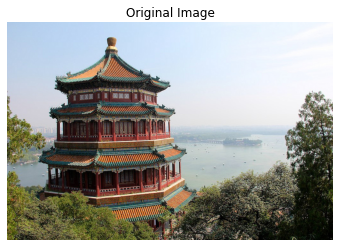

In [ ]:
from sklearn.datasets import load_sample_images

img = load_sample_images()["images"][0]
plt.imshow(img)
plt.axis("off")
plt.title("Original Image")
plt.show()

In [ ]:
data = tf.io.encode_jpeg(img)
example_with_image = Example(features=Features(feature={
    "image": Feature(bytes_list=BytesList(value=[data.numpy()]))}))
serialized_example = example_with_image.SerializeToString()
# then save to TFRecord

In [ ]:
feature_description = { "image": tf.io.VarLenFeature(tf.string) }
example_with_image = tf.io.parse_single_example(serialized_example, feature_description)
decoded_img = tf.io.decode_jpeg(example_with_image["image"].values[0])

Or use `decode_image()` which supports BMP, GIF, JPEG and PNG formats:

In [ ]:
decoded_img = tf.io.decode_image(example_with_image["image"].values[0])

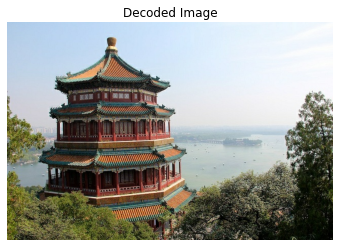

In [ ]:
plt.imshow(decoded_img)
plt.title("Decoded Image")
plt.axis("off")
plt.show()

## Putting Tensors and Sparse Tensors in TFRecords

Tensors can be serialized and parsed easily using `tf.io.serialize_tensor()` and `tf.io.parse_tensor()`:

In [ ]:
t = tf.constant([[0., 1.], [2., 3.], [4., 5.]])
s = tf.io.serialize_tensor(t)
s

<tf.Tensor: shape=(), dtype=string, numpy=b'\x08\x01\x12\x08\x12\x02\x08\x03\x12\x02\x08\x02"\x18\x00\x00\x00\x00\x00\x00\x80?\x00\x00\x00@\x00\x00@@\x00\x00\x80@\x00\x00\xa0@'>

In [ ]:
tf.io.parse_tensor(s, out_type=tf.float32)

<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
array([[0., 1.],
       [2., 3.],
       [4., 5.]], dtype=float32)>

In [ ]:
serialized_sparse = tf.io.serialize_sparse(parsed_example["emails"])
serialized_sparse

<tf.Tensor: shape=(3,), dtype=string, numpy=
array([b'\x08\t\x12\x08\x12\x02\x08\x02\x12\x02\x08\x01"\x10\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x00\x00\x00\x00',
       b'\x08\x07\x12\x04\x12\x02\x08\x02"\x10\x07\x07a@b.comc@d.com',
       b'\x08\t\x12\x04\x12\x02\x08\x01"\x08\x02\x00\x00\x00\x00\x00\x00\x00'],
      dtype=object)>

In [ ]:
BytesList(value=serialized_sparse.numpy())

value: "\010\t\022\010\022\002\010\002\022\002\010\001\"\020\000\000\000\000\000\000\000\000\001\000\000\000\000\000\000\000"
value: "\010\007\022\004\022\002\010\002\"\020\007\007a@b.comc@d.com"
value: "\010\t\022\004\022\002\010\001\"\010\002\000\000\000\000\000\000\000"

In [ ]:
dataset = tf.data.TFRecordDataset(["my_contacts.tfrecord"]).batch(10)
for serialized_examples in dataset:
    parsed_examples = tf.io.parse_example(serialized_examples,
                                          feature_description)

In [ ]:
parsed_examples

{'image': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd6406f5d50>}

## Handling Sequential Data Using `SequenceExample`

```proto
syntax = "proto3";

message FeatureList { repeated Feature feature = 1; };
message FeatureLists { map<string, FeatureList> feature_list = 1; };
message SequenceExample {
  Features context = 1;
  FeatureLists feature_lists = 2;
};
```

**Warning**: in TensorFlow 2.0 and 2.1, there was a bug preventing `from tensorflow.train import X` so we work around it by writing `X = tf.train.X`. See https://github.com/tensorflow/tensorflow/issues/33289 for more details.

In [ ]:
#from tensorflow.train import FeatureList, FeatureLists, SequenceExample
FeatureList = tf.train.FeatureList
FeatureLists = tf.train.FeatureLists
SequenceExample = tf.train.SequenceExample

context = Features(feature={
    "author_id": Feature(int64_list=Int64List(value=[123])),
    "title": Feature(bytes_list=BytesList(value=[b"A", b"desert", b"place", b"."])),
    "pub_date": Feature(int64_list=Int64List(value=[1623, 12, 25]))
})

content = [["When", "shall", "we", "three", "meet", "again", "?"],
           ["In", "thunder", ",", "lightning", ",", "or", "in", "rain", "?"]]
comments = [["When", "the", "hurlyburly", "'s", "done", "."],
            ["When", "the", "battle", "'s", "lost", "and", "won", "."]]

def words_to_feature(words):
    return Feature(bytes_list=BytesList(value=[word.encode("utf-8")
                                               for word in words]))

content_features = [words_to_feature(sentence) for sentence in content]
comments_features = [words_to_feature(comment) for comment in comments]
            
sequence_example = SequenceExample(
    context=context,
    feature_lists=FeatureLists(feature_list={
        "content": FeatureList(feature=content_features),
        "comments": FeatureList(feature=comments_features)
    }))

In [ ]:
sequence_example

context {
  feature {
    key: "author_id"
    value {
      int64_list {
        value: 123
      }
    }
  }
  feature {
    key: "pub_date"
    value {
      int64_list {
        value: 1623
        value: 12
        value: 25
      }
    }
  }
  feature {
    key: "title"
    value {
      bytes_list {
        value: "A"
        value: "desert"
        value: "place"
        value: "."
      }
    }
  }
}
feature_lists {
  feature_list {
    key: "comments"
    value {
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "hurlyburly"
          value: "\'s"
          value: "done"
          value: "."
        }
      }
      feature {
        bytes_list {
          value: "When"
          value: "the"
          value: "battle"
          value: "\'s"
          value: "lost"
          value: "and"
          value: "won"
          value: "."
        }
      }
    }
  }
  feature_list {
    key: "content"
    value {
      feature {
      

In [ ]:
serialized_sequence_example = sequence_example.SerializeToString()

In [ ]:
context_feature_descriptions = {
    "author_id": tf.io.FixedLenFeature([], tf.int64, default_value=0),
    "title": tf.io.VarLenFeature(tf.string),
    "pub_date": tf.io.FixedLenFeature([3], tf.int64, default_value=[0, 0, 0]),
}
sequence_feature_descriptions = {
    "content": tf.io.VarLenFeature(tf.string),
    "comments": tf.io.VarLenFeature(tf.string),
}
parsed_context, parsed_feature_lists = tf.io.parse_single_sequence_example(
    serialized_sequence_example, context_feature_descriptions,
    sequence_feature_descriptions)

In [ ]:
parsed_context

{'title': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd621092610>,
 'author_id': <tf.Tensor: shape=(), dtype=int64, numpy=123>,
 'pub_date': <tf.Tensor: shape=(3,), dtype=int64, numpy=array([1623,   12,   25])>}

In [ ]:
parsed_context["title"].values

<tf.Tensor: shape=(4,), dtype=string, numpy=array([b'A', b'desert', b'place', b'.'], dtype=object)>

In [ ]:
parsed_feature_lists

{'comments': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd621092790>,
 'content': <tensorflow.python.framework.sparse_tensor.SparseTensor at 0x7fd621092b50>}

In [ ]:
print(tf.RaggedTensor.from_sparse(parsed_feature_lists["content"]))

<tf.RaggedTensor [[b'When', b'shall', b'we', b'three', b'meet', b'again', b'?'], [b'In', b'thunder', b',', b'lightning', b',', b'or', b'in', b'rain', b'?']]>


# The Features API

Let's use the variant of the California housing dataset that we used in Chapter 2, since it contains categorical features and missing values:

In [ ]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    os.makedirs(housing_path, exist_ok=True)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [ ]:
fetch_housing_data()

In [ ]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [ ]:
housing = load_housing_data()
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [ ]:
housing_median_age = tf.feature_column.numeric_column("housing_median_age")

In [ ]:
age_mean, age_std = X_mean[1], X_std[1]  # The median age is column in 1
housing_median_age = tf.feature_column.numeric_column(
    "housing_median_age", normalizer_fn=lambda x: (x - age_mean) / age_std)

In [ ]:
median_income = tf.feature_column.numeric_column("median_income")
bucketized_income = tf.feature_column.bucketized_column(
    median_income, boundaries=[1.5, 3., 4.5, 6.])

In [ ]:
bucketized_income

BucketizedColumn(source_column=NumericColumn(key='median_income', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), boundaries=(1.5, 3.0, 4.5, 6.0))

In [ ]:
ocean_prox_vocab = ['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN']
ocean_proximity = tf.feature_column.categorical_column_with_vocabulary_list(
    "ocean_proximity", ocean_prox_vocab)

In [ ]:
ocean_proximity

VocabularyListCategoricalColumn(key='ocean_proximity', vocabulary_list=('<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'), dtype=tf.string, default_value=-1, num_oov_buckets=0)

In [ ]:
# Just an example, it's not used later on
city_hash = tf.feature_column.categorical_column_with_hash_bucket(
    "city", hash_bucket_size=1000)
city_hash

HashedCategoricalColumn(key='city', hash_bucket_size=1000, dtype=tf.string)

In [ ]:
bucketized_age = tf.feature_column.bucketized_column(
    housing_median_age, boundaries=[-1., -0.5, 0., 0.5, 1.]) # age was scaled
age_and_ocean_proximity = tf.feature_column.crossed_column(
    [bucketized_age, ocean_proximity], hash_bucket_size=100)

In [ ]:
latitude = tf.feature_column.numeric_column("latitude")
longitude = tf.feature_column.numeric_column("longitude")
bucketized_latitude = tf.feature_column.bucketized_column(
    latitude, boundaries=list(np.linspace(32., 42., 20 - 1)))
bucketized_longitude = tf.feature_column.bucketized_column(
    longitude, boundaries=list(np.linspace(-125., -114., 20 - 1)))
location = tf.feature_column.crossed_column(
    [bucketized_latitude, bucketized_longitude], hash_bucket_size=1000)

In [ ]:
ocean_proximity_one_hot = tf.feature_column.indicator_column(ocean_proximity)

In [ ]:
ocean_proximity_embed = tf.feature_column.embedding_column(ocean_proximity,
                                                           dimension=2)

## Using Feature Columns for Parsing

In [ ]:
median_house_value = tf.feature_column.numeric_column("median_house_value")

In [ ]:
columns = [housing_median_age, median_house_value]
feature_descriptions = tf.feature_column.make_parse_example_spec(columns)
feature_descriptions

{'housing_median_age': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None),
 'median_house_value': FixedLenFeature(shape=(1,), dtype=tf.float32, default_value=None)}

In [ ]:
with tf.io.TFRecordWriter("my_data_with_features.tfrecords") as f:
    for x, y in zip(X_train[:, 1:2], y_train):
        example = Example(features=Features(feature={
            "housing_median_age": Feature(float_list=FloatList(value=[x])),
            "median_house_value": Feature(float_list=FloatList(value=[y]))
        }))
        f.write(example.SerializeToString())

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
def parse_examples(serialized_examples):
    examples = tf.io.parse_example(serialized_examples, feature_descriptions)
    targets = examples.pop("median_house_value") # separate the targets
    return examples, targets

batch_size = 32
dataset = tf.data.TFRecordDataset(["my_data_with_features.tfrecords"])
dataset = dataset.repeat().shuffle(10000).batch(batch_size).map(parse_examples)

**Warning**: the `DenseFeatures` layer currently does not work with the Functional API, see [TF issue #27416](https://github.com/tensorflow/tensorflow/issues/27416). Hopefully this will be resolved before the final release of TF 2.0.

In [ ]:
columns_without_target = columns[:-1]
model = keras.models.Sequential([
    keras.layers.DenseFeatures(feature_columns=columns_without_target),
    keras.layers.Dense(1)
])
model.compile(loss="mse",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(dataset, steps_per_epoch=len(X_train) // batch_size, epochs=5)

Epoch 1/5
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
362/362 [==============================] - 0s 675us/step - loss: 4.7553 - accuracy: 8.8428e-04
Epoch 2/5
362/362 [==============================] - 0s 622us/step - loss: 2.1622 - accuracy: 0.0021
Epoch 3/5
362/362 [==============================] - 0s 583us/step - loss: 1.4673 - accuracy: 0.0032
Epoch 4/5
362/362 [==============================] - 0s 543us/step - loss: 1.3786 - accuracy: 0.0033
Epoch 5/5
362/362 [==============================] - 0s 537us/step - loss: 1.3404 - accuracy: 0.0034


In [ ]:
some_columns = [ocean_proximity_embed, bucketized_income]
dense_features = keras.layers.DenseFeatures(some_columns)
dense_features({
    "ocean_proximity": [["NEAR OCEAN"], ["INLAND"], ["INLAND"]],
    "median_income": [[3.], [7.2], [1.]]
})

<tf.Tensor: shape=(3, 7), dtype=float32, numpy=
array([[ 0.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        -0.14504611,  0.7563394 ],
       [ 0.        ,  0.        ,  0.        ,  0.        ,  1.        ,
        -1.1119912 ,  0.56957847],
       [ 1.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        -1.1119912 ,  0.56957847]], dtype=float32)>

# Preprocessing the Input Features

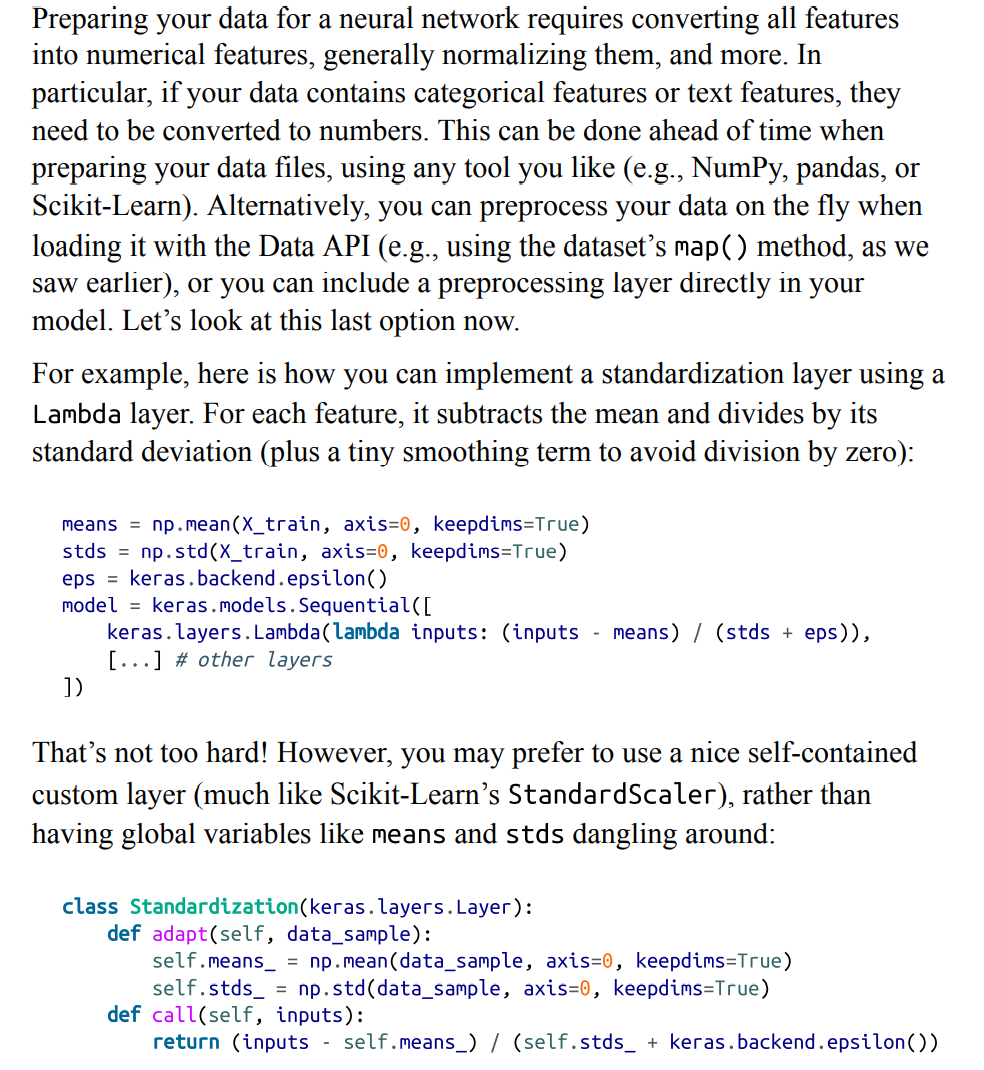

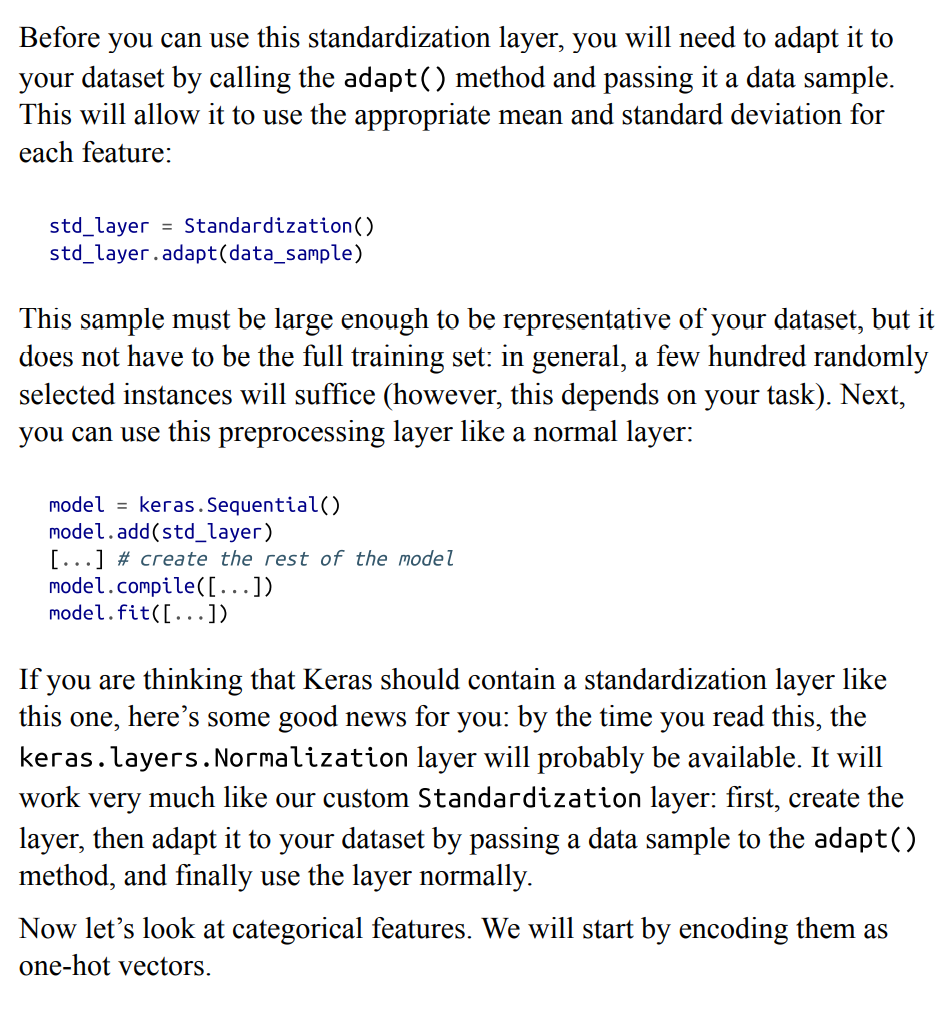

### Encoding Categorical Features using One-Hot Vectors

Consider the ocean_proximity feature in the California housing dataset we
explored in Chapter 2: it is a categorical feature with five possible values: "
<1H OCEAN", "INLAND", "NEAR OCEAN", "NEAR BAY", and "ISLAND". We
need to encode this feature before we feed it to a neural network. Since
there are very few categories, we can use one-hot encoding. For this, we
first need to map each category to its index (0 to 4), which can be done
using a lookup table:

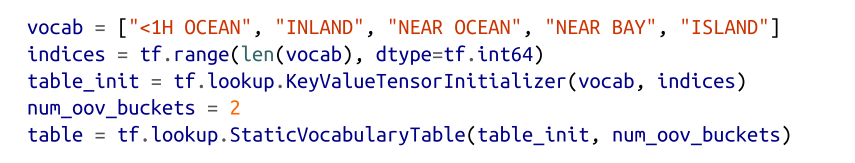

Let’s go through this code:

- We first define the vocabulary: this is the list of all possible
categories.
- Then we create a tensor with the corresponding indices (0 to 4).
- Next, we create an initializer for the lookup table, passing it the list
of categories and their corresponding indices. In this example, we
already have this data, so we use a KeyValueTensorInitializer;
but if the categories were listed in a text file (with one category per
line), we would use a TextFileInitializer instead.
- In the last two lines we create the lookup table, giving it the
initializer and specifying the number of out-of-vocabulary (oov)
buckets. If we look up a category that does not exist in the
vocabulary, the lookup table will compute a hash of this category
and use it to assign the unknown category to one of the oov
buckets. Their indices start after the known categories, so in this
example the indices of the two oov buckets are 5 and 6.

Why use oov buckets? Well, if the number of categories is large (e.g., zip
codes, cities, words, products, or users) and the dataset is large as well, or it
keeps changing, then getting the full list of categories may not be
convenient. One solution is to define the vocabulary based on a data sample
(rather than the whole training set) and add some oov buckets for the other
categories that were not in the data sample. The more unknown categories
you expect to find during training, the more oov buckets you should use.
Indeed, if there are not enough oov buckets, there will be collisions:
different categories will end up in the same bucket, so the neural network
will not be able to distinguish them (at least not based on this feature).
Now let’s use the lookup table to encode a small batch of categorical
features to one-hot vectors:

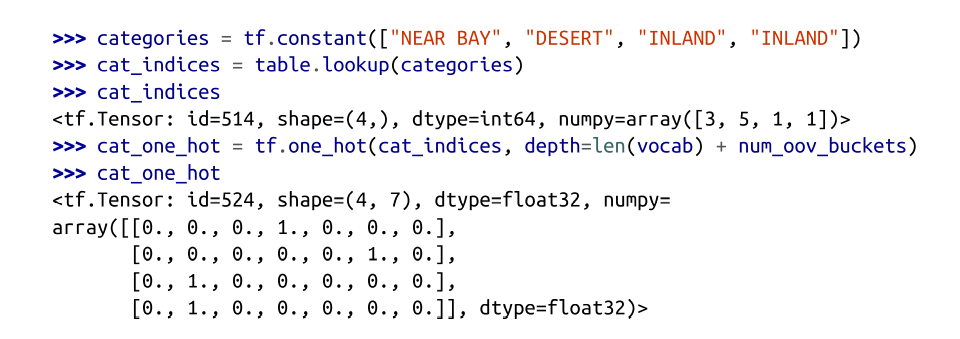

As you can see, "NEAR BAY" was mapped to index 3, the unknown category
"DESERT" was mapped to one of the two oov buckets (at index 5), and
"INLAND" was mapped to index 1, twice. Then we used tf.one_hot() to
one-hot encode these indices. Notice that we have to tell this function the
total number of indices, which is equal to the vocabulary size plus the
number of oov buckets. Now you know how to encode categorical features
to one-hot vectors using TensorFlow!

Just like earlier, it wouldn’t be too difficult to bundle all of this logic into a
nice self-contained class. Its adapt() method would take a data sample and
extract all the distinct categories it contains. It would create a lookup table
to map each category to its index (including unknown categories using oov
buckets). Then its call() method would use the lookup table to map the
input categories to their indices. Well, here’s more good news: by the time
you read this, Keras will probably include a layer called
keras.layers.TextVectorization, which will be capable of doing
exactly that: its adapt() method will extract the vocabulary from a data
sample, and its call() method will convert each category to its index in the
vocabulary. You could add this layer at the beginning of your model,
followed by a Lambda layer that would apply the tf.one_hot() function, if
you want to convert these indices to one-hot vectors.

This may not be the best solution, though. The size of each one-hot vector
is the vocabulary length plus the number of oov buckets. This is fine when
there are just a few possible categories, but if the vocabulary is large, it is
much more efficient to encode them using embeddings instead.

### Encoding Categorical Features using Embeddings

An embedding is a trainable dense vector that represents a category. By
default, embeddings are initialized randomly, so for example the "NEAR
BAY" category could be represented initially by a random vector such as
[0.131, 0.890], while the "NEAR OCEAN" category might be represented
by another random vector such as [0.631, 0.791]. In this example, we
use 2D embeddings, but the number of dimensions is a hyperparameter you
can tweak. Since these embeddings are trainable, they will gradually
improve during training; and as they represent fairly similar categories,
Gradient Descent will certainly end up pushing them closer together, while
it will tend to move them away from the "INLAND" category’s embedding
(see Figure 13-4). Indeed, the better the representation, the easier it will be
for the neural network to make accurate predictions, so training tends to
make embeddings useful representations of the categories. This is called
representation learning (we will see other types of representation learning
in Chapter 17)

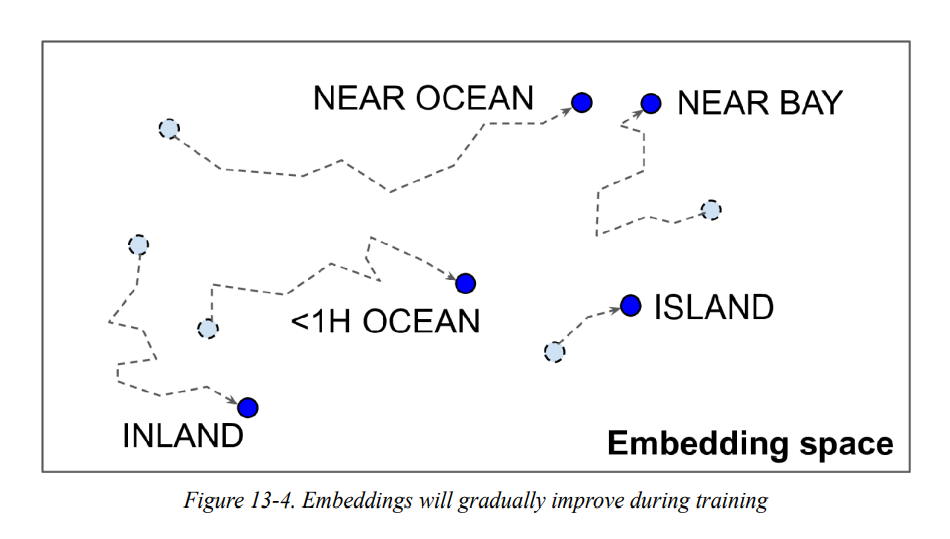

WORD EMBEDDINGS

Not only will embeddings generally be useful representations for the
task at hand, but quite often these same embeddings can be reused
successfully for other tasks. The most common example of this is word
embeddings (i.e., embeddings of individual words): when you are
working on a natural language processing task, you are often better off
reusing pretrained word embeddings than training your own.
The idea of using vectors to represent words dates back to the 1960s,
and many sophisticated techniques have been used to generate useful
vectors, including using neural networks. But things really took off in
2013, when Tomáš Mikolov and other Google researchers published a
paper describing an efficient technique to learn word embeddings
using neural networks, significantly outperforming previous attempts.
This allowed them to learn embeddings on a very large corpus of text:
they trained a neural network to predict the words near any given word,
and obtained astounding word embeddings. For example, synonyms
had very close embeddings, and semantically related words such as
France, Spain, and Italy ended up clustered together.
It’s not just about proximity, though: word embeddings were also
organized along meaningful axes in the embedding space. Here is a
famous example: if you compute King – Man + Woman (adding and
subtracting the embedding vectors of these words), then the result will
be very close to the embedding of the word Queen (see Figure 13-5). In
other words, the word embeddings encode the concept of gender!
Similarly, you can compute Madrid – Spain + France, and the result is
close to Paris, which seems to show that the notion of capital city was
also encoded in the embeddings.

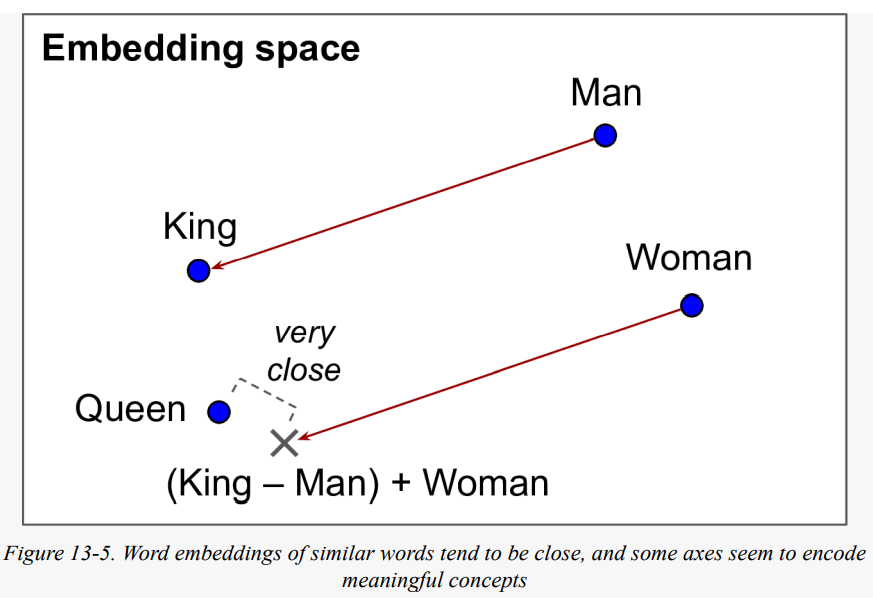

Unfortunately, word embeddings sometimes capture our worst biases.
For example, although they correctly learn that Man is to King as
Woman is to Queen, they also seem to learn that Man is to Doctor as
Woman is to Nurse: quite a sexist bias! To be fair, this particular
example is probably exaggerated, as was pointed out in a 2019 paper
by Malvina Nissim et al. Nevertheless, ensuring fairness in Deep
Learning algorithms is an important and active research topic.


Let’s look at how we could implement embeddings manually, to understand
how they work (then we will use a simple Keras layer instead). First, we
need to create an embedding matrix containing each category’s embedding,
initialized randomly; it will have one row per category and per oov bucket,
and one column per embedding dimension:

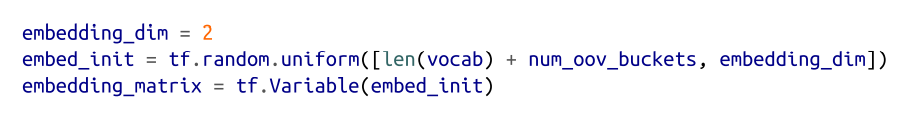

In this example we are using 2D embeddings, but as a rule of thumb
embeddings typically have 10 to 300 dimensions, depending on the task and
the vocabulary size (you will have to tune this hyperparameter).
This embedding matrix is a random 6 × 2 matrix, stored in a variable (so it
can be tweaked by Gradient Descent during training):

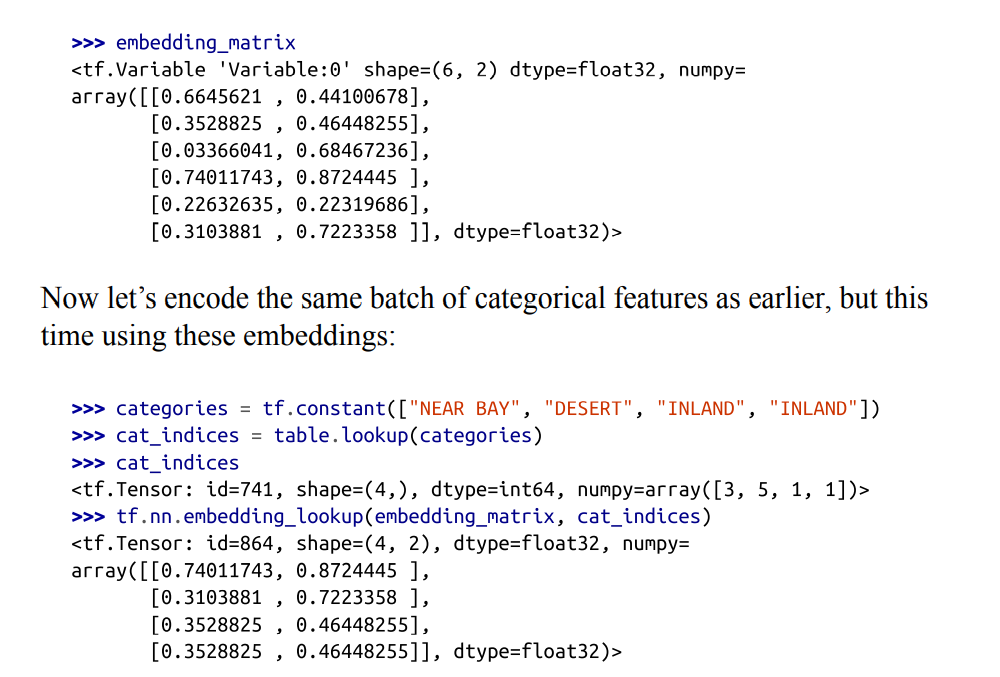

The tf.nn.embedding_lookup() function looks up the rows in the
embedding matrix, at the given indices—that’s all it does. For example, the
lookup table says that the "INLAND" category is at index 1, so the
tf.nn.embedding_lookup() function returns the embedding at row 1 in
the embedding matrix (twice): [0.3528825, 0.46448255].

Keras provides a keras.layers.Embedding layer that handles the
embedding matrix (trainable, by default); when the layer is created it
initializes the embedding matrix randomly, and then when it is called with
some category indices it returns the rows at those indices in the embedding
matrix:

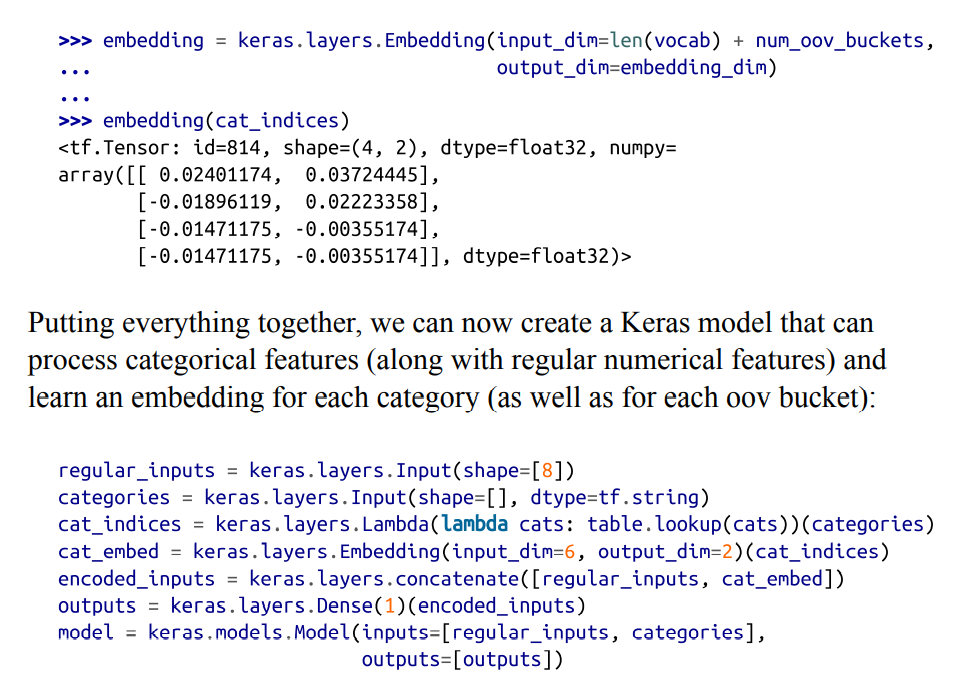

This model takes two inputs: a regular input containing eight numerical
features per instance, plus a categorical input (containing one categorical
feature per instance). It uses a Lambda layer to look up each category’s
index, then it looks up the embeddings for these indices. Next, it
concatenates the embeddings and the regular inputs in order to give the
encoded inputs, which are ready to be fed to a neural network. We could
add any kind of neural network at this point, but we just add a dense output
layer, and we create the Keras model.
When the keras.layers.TextVectorization layer is available, you can
call its adapt() method to make it extract the vocabulary from a data
sample (it will take care of creating the lookup table for you). Then you can
add it to your model, and it will perform the index lookup (replacing the
Lambda layer in the previous code example).

NOTE

One-hot encoding followed by a Dense layer (with no activation function and no biases)
is equivalent to an Embedding layer. However, the Embedding layer uses way fewer
computations (the performance difference becomes clear when the size of the
embedding matrix grows). The Dense layer’s weight matrix plays the role of the
embedding matrix. For example, using one-hot vectors of size 20 and a Dense layer with
10 units is equivalent to using an Embedding layer with input_dim=20 and
output_dim=10. As a result, it would be wasteful to use more embedding dimensions
than the number of units in the layer that follows the Embedding layer.

## Keras Preprocessing layers

Keras Preprocessing Layers
The TensorFlow team is working on providing a set of standard Keras
preprocessing layers. They will probably be available by the time you read
this; however, the API may change slightly by then, so please refer to the
notebook for this chapter if anything behaves unexpectedly. This new API
will likely supersede the existing Feature Columns API, which is harder to
use and less intuitive (if you want to learn more about the Feature Columns
API anyway, please check out the notebook for this chapter).

We already discussed two of these layers: the
keras.layers.Normalization layer that will perform feature
standardization (it will be equivalent to the Standardization layer we
defined earlier), and the TextVectorization layer that will be capable of
encoding each word in the inputs into its index in the vocabulary. In both
cases, you create the layer, you call its adapt() method with a data sample,
and then you use the layer normally in your model. The other preprocessing
layers will follow the same pattern.

The API will also include a keras.layers.Discretization layer that will
chop continuous data into different bins and encode each bin as a one-hot
vector. For example, you could use it to discretize prices into three
categories, (low, medium, high), which would be encoded as [1, 0, 0], [0, 1,
0], and [0, 0, 1], respectively. Of course this loses a lot of information, but
in some cases it can help the model detect patterns that would otherwise not
be obvious when just looking at the continuous values.

WARNING

The Discretization layer will not be differentiable, and it should only be used at the
start of your model. Indeed, the model’s preprocessing layers will be frozen during
training, so their parameters will not be affected by Gradient Descent, and thus they do
not need to be differentiable. This also means that you should not use an Embedding
layer directly in a custom preprocessing layer, if you want it to be trainable: instead, it
should be added separately to your model, as in the previous code example.

It will also be possible to chain multiple preprocessing layers using the
PreprocessingStage class. For example, the following code will create a
preprocessing pipeline that will first normalize the inputs, then discretize
them (this may remind you of Scikit-Learn pipelines). After you adapt this
pipeline to a data sample, you can use it like a regular layer in your models
(but again, only at the start of the model, since it contains a
nondifferentiable preprocessing layer):

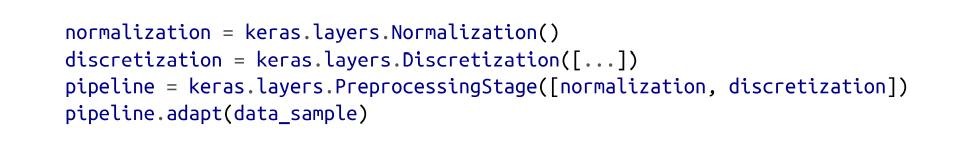

The TextVectorization layer will also have an option to output wordcount vectors instead of word indices. For example, if the vocabulary
contains three words, say ["and", "basketball", "more"], then the text
"more and more" will be mapped to the vector [1, 0, 2]: the word
"and" appears once, the word "basketball" does not appear at all, and the
word "more" appears twice. This text representation is called a bag of
words, since it completely loses the order of the words. Common words like
"and" will have a large value in most texts, even though they are usually
the least interesting (e.g., in the text "more and more basketball" the
word "basketball" is clearly the most important, precisely because it is
not a very frequent word). So, the word counts should be normalized in a
way that reduces the importance of frequent words. A common way to do
this is to divide each word count by the log of the total number of training
instances in which the word appears. This technique is called TermFrequency × Inverse-Document-Frequency (TF-IDF). For example, let’s
imagine that the words "and", "basketball", and "more" appear
respectively in 200, 10, and 100 text instances in the training set: in this
case, the final vector will be [1/log(200), 0/log(10), 2/log(100)],
which is approximately equal to [0.19, 0., 0.43]. The
TextVectorization layer will (likely) have an option to perform TF-IDF.

NOTE

If the standard preprocessing layers are insufficient for your task, you will still have the
option to create your own custom preprocessing layer, much like we did earlier with the
Standardization class. Create a subclass of the keras.layers.PreprocessingLayer
class with an adapt() method, which should take a data_sample argument and
optionally an extra reset_state argument: if True, then the adapt() method should
reset any existing state before computing the new state; if False, it should try to update
the existing state.

As you can see, these Keras preprocessing layers will make preprocessing
much easier! Now, whether you choose to write your own preprocessing
layers or use Keras’s (or even use the Feature Columns API), all the
preprocessing will be done on the fly. During training, however, it may be
preferable to perform preprocessing ahead of time. Let’s see why we’d want
to do that and how we’d go about it.

# TF Transform

If preprocessing is computationally expensive, then handling it before
training rather than on the fly may give you a significant speedup: the data
will be preprocessed just once per instance before training, rather than once
per instance and per epoch during training. As mentioned earlier, if the
dataset is small enough to fit in RAM, you can use its cache() method. But
if it is too large, then tools like Apache Beam or Spark will help. They let
you run efficient data processing pipelines over large amounts of data, even
distributed across multiple servers, so you can use them to preprocess all
the training data before training.

This works great and indeed can speed up training, but there is one
problem: once your model is trained, suppose you want to deploy it to a
mobile app. In that case you will need to write some code in your app to
take care of preprocessing the data before it is fed to the model. And
suppose you also want to deploy the model to TensorFlow.js so that it runs
in a web browser? Once again, you will need to write some preprocessing
code. This can become a maintenance nightmare: whenever you want to
change the preprocessing logic, you will need to update your Apache Beam
code, your mobile app code, and your JavaScript code. This is not only
time-consuming, but also error-prone: you may end up with subtle
differences between the preprocessing operations performed before training
and the ones performed in your app or in the browser. This training/serving
skew will lead to bugs or degraded performance.

One improvement would be to take the trained model (trained on data that
was preprocessed by your Apache Beam or Spark code) and, before
deploying it to your app or the browser, add extra preprocessing layers to
take care of preprocessing on the fly. That’s definitely better, since now you
just have two versions of your preprocessing code: the Apache Beam or
Spark code, and the preprocessing layers’ code.

But what if you could define your preprocessing operations just once? This
is what TF Transform was designed for. It is part of TensorFlow Extended
(TFX), an end-to-end platform for productionizing TensorFlow models.

First, to use a TFX component such as TF Transform, you must install it; it
does not come bundled with TensorFlow. You then define your
preprocessing function just once (in Python), by using TF Transform
functions for scaling, bucketizing, and more. You can also use any
TensorFlow operation you need. Here is what this preprocessing function
might look like if we just had two features:

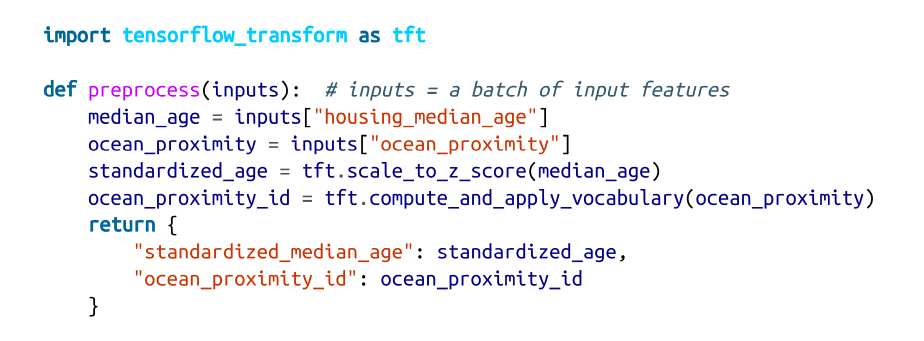

In [ ]:
try:
    import tensorflow_transform as tft

    def preprocess(inputs):  # inputs is a batch of input features
        median_age = inputs["housing_median_age"]
        ocean_proximity = inputs["ocean_proximity"]
        standardized_age = tft.scale_to_z_score(median_age - tft.mean(median_age))
        ocean_proximity_id = tft.compute_and_apply_vocabulary(ocean_proximity)
        return {
            "standardized_median_age": standardized_age,
            "ocean_proximity_id": ocean_proximity_id
        }
except ImportError:
    print("TF Transform is not installed. Try running: pip3 install -U tensorflow-transform")

Next, TF Transform lets you apply this preprocess() function to the
whole training set using Apache Beam (it provides an
AnalyzeAndTransformDataset class that you can use for this purpose in
your Apache Beam pipeline). In the process, it will also compute all the
necessary statistics over the whole training set: in this example, the mean
and standard deviation of the housing_median_age feature, and the
vocabulary for the ocean_proximity feature. The components that
compute these statistics are called analyzers.

Importantly, TF Transform will also generate an equivalent TensorFlow
Function that you can plug into the model you deploy. This TF Function
includes some constants that correspond to all the all the necessary statistics
computed by Apache Beam (the mean, standard deviation, and vocabulary).

With the Data API, TFRecords, the Keras preprocessing layers, and TF
Transform, you can build highly scalable input pipelines for training and
benefit from fast and portable data preprocessing in production.

But what if you just wanted to use a standard dataset? Well in that case,
things are much simpler: just use TFDS!


# TensorFlow Datasets (TFDS) Project

The TensorFlow Datasets project makes it very easy to download common
datasets, from small ones like MNIST or Fashion MNIST to huge datasets
like ImageNet (you will need quite a bit of disk space!). The list includes
image datasets, text datasets (including translation datasets), and audio and
video datasets. You can visit https://homl.info/tfds to view the full list, along
with a description of each dataset.

TFDS is not bundled with TensorFlow, so you need to install the
tensorflow-datasets library (e.g., using pip). Then call the tfds.load()
function, and it will download the data you want (unless it was already
downloaded earlier) and return the data as a dictionary of datasets (typically
one for training and one for testing, but this depends on the dataset you
choose). For example, let’s download MNIST:

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]

/Users/ageron/tensorflow_datasets/mnist/3.0.0
Using /Users/ageron/tensorflow_datasets/mnist/3.0.1 instead.


local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead set
data_dir=gs://tfds-data/datasets.



Dl Completed...:   0%|          | 0/4 [00:00<?, ? file/s]


Dataset mnist downloaded and prepared to /Users/ageron/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
print(tfds.list_builders())

['abstract_reasoning', 'aeslc', 'aflw2k3d', 'amazon_us_reviews', 'arc', 'bair_robot_pushing_small', 'beans', 'big_patent', 'bigearthnet', 'billsum', 'binarized_mnist', 'binary_alpha_digits', 'blimp', 'c4', 'caltech101', 'caltech_birds2010', 'caltech_birds2011', 'cars196', 'cassava', 'cats_vs_dogs', 'celeb_a', 'celeb_a_hq', 'cfq', 'chexpert', 'cifar10', 'cifar100', 'cifar10_1', 'cifar10_corrupted', 'citrus_leaves', 'cityscapes', 'civil_comments', 'clevr', 'cmaterdb', 'cnn_dailymail', 'coco', 'coil100', 'colorectal_histology', 'colorectal_histology_large', 'common_voice', 'cos_e', 'crema_d', 'curated_breast_imaging_ddsm', 'cycle_gan', 'deep_weeds', 'definite_pronoun_resolution', 'dementiabank', 'diabetic_retinopathy_detection', 'div2k', 'dmlab', 'downsampled_imagenet', 'dsprites', 'dtd', 'duke_ultrasound', 'emnist', 'eraser_multi_rc', 'esnli', 'eurosat', 'fashion_mnist', 'flic', 'flores', 'food101', 'forest_fires', 'gap', 'geirhos_conflict_stimuli', 'german_credit_numeric', 'gigaword', '

You can then apply any transformation you want (typically shuffling,
batching, and prefetching), and you’re ready to train your model. Here is a
simple example:

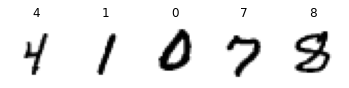

In [ ]:
plt.figure(figsize=(6,3))
mnist_train = mnist_train.repeat(5).batch(32).prefetch(1)
for item in mnist_train:
    images = item["image"]
    labels = item["label"]
    for index in range(5):
        plt.subplot(1, 5, index + 1)
        image = images[index, ..., 0]
        label = labels[index].numpy()
        plt.imshow(image, cmap="binary")
        plt.title(label)
        plt.axis("off")
    break # just showing part of the first batch

TIP

The load() function shuffles each data shard it downloads (only for the training set).
This may not be sufficient, so it’s best to shuffle the training data some more.

Note that each item in the dataset is a dictionary containing both the
features and the labels. But Keras expects each item to be a tuple containing
two elements (again, the features and the labels). You could transform the
dataset using the map() method, like this:

In [ ]:
datasets = tfds.load(name="mnist")
mnist_train, mnist_test = datasets["train"], datasets["test"]
mnist_train = mnist_train.repeat(5).batch(32)
mnist_train = mnist_train.map(lambda items: (items["image"], items["label"]))
mnist_train = mnist_train.prefetch(1)
for images, labels in mnist_train.take(1):
    print(images.shape)
    print(labels.numpy())

(32, 28, 28, 1)
[4 1 0 7 8 1 2 7 1 6 6 4 7 7 3 3 7 9 9 1 0 6 6 9 9 4 8 9 4 7 3 3]


In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

But it’s simpler to ask the load() function to do this for you by setting
as_supervised=True (obviously this works only for labeled datasets). You
can also specify the batch size if you want. Then you can pass the dataset
directly to your tf.keras model:


In [ ]:
datasets = tfds.load(name="mnist", batch_size=32, as_supervised=True)
mnist_train = datasets["train"].repeat().prefetch(1)
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28, 1]),
    keras.layers.Lambda(lambda images: tf.cast(images, tf.float32)),
    keras.layers.Dense(10, activation="softmax")])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3),
              metrics=["accuracy"])
model.fit(mnist_train, steps_per_epoch=60000 // 32, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 2s 997us/step - loss: 42.8499 - accuracy: 0.8034
Epoch 2/5
1875/1875 [==============================] - 1s 481us/step - loss: 25.1669 - accuracy: 0.8687
Epoch 3/5
1875/1875 [==============================] - 1s 460us/step - loss: 24.1730 - accuracy: 0.8744
Epoch 4/5
1875/1875 [==============================] - 1s 446us/step - loss: 23.7216 - accuracy: 0.8760
Epoch 5/5
1875/1875 [==============================] - 1s 444us/step - loss: 23.1382 - accuracy: 0.8786


# TensorFlow Hub

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
import tensorflow_hub as hub

hub_layer = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim50/2",
                           output_shape=[50], input_shape=[], dtype=tf.string)

model = keras.Sequential()
model.add(hub_layer)
model.add(keras.layers.Dense(16, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 50)                48190600  
_________________________________________________________________
dense (Dense)                (None, 16)                816       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


In [ ]:
sentences = tf.constant(["It was a great movie", "The actors were amazing"])
embeddings = hub_layer(sentences)

In [ ]:
embeddings

<tf.Tensor: shape=(2, 50), dtype=float32, numpy=
array([[ 7.45939985e-02,  2.76720114e-02,  9.38646123e-02,
         1.25124469e-01,  5.40293928e-04, -1.09435350e-01,
         1.34755149e-01, -9.57818255e-02, -1.85177118e-01,
        -1.69703495e-02,  1.75612606e-02, -9.06603858e-02,
         1.12110220e-01,  1.04646273e-01,  3.87700424e-02,
        -7.71859884e-02, -3.12189370e-01,  6.99466765e-02,
        -4.88970093e-02, -2.99049795e-01,  1.31183028e-01,
        -2.12630898e-01,  6.96169436e-02,  1.63592950e-01,
         1.05169769e-02,  7.79720694e-02, -2.55230188e-01,
        -1.80790052e-01,  2.93739915e-01,  1.62875261e-02,
        -2.80566931e-01,  1.60284728e-01,  9.87277832e-03,
         8.44555616e-04,  8.39456245e-02,  3.24002892e-01,
         1.53253034e-01, -3.01048346e-02,  8.94618109e-02,
        -2.39153411e-02, -1.50188789e-01, -1.81733668e-02,
        -1.20483577e-01,  1.32937476e-01, -3.35325629e-01,
        -1.46504581e-01, -1.25251599e-02, -1.64428815e-01,
       

# Summary

This was quite a technical chapter, and you may feel that it is a bit far from
the abstract beauty of neural networks, but the fact is Deep Learning often
involves large amounts of data, and knowing how to load, parse, and
preprocess it efficiently is a crucial skill to have. In the next chapter, we
will look at convolutional neural networks, which are among the most
successful neural net architectures for image processing and many other
applications.


# Exercises

## 1. to 8.
See Appendix A

## 9.
### a.
_Exercise: Load the Fashion MNIST dataset (introduced in Chapter 10); split it into a training set, a validation set, and a test set; shuffle the training set; and save each dataset to multiple TFRecord files. Each record should be a serialized `Example` protobuf with two features: the serialized image (use `tf.io.serialize_tensor()` to serialize each image), and the label. Note: for large images, you could use `tf.io.encode_jpeg()` instead. This would save a lot of space, but it would lose a bit of image quality._

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
train_set = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train))
valid_set = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))
test_set = tf.data.Dataset.from_tensor_slices((X_test, y_test))

In [ ]:
def create_example(image, label):
    image_data = tf.io.serialize_tensor(image)
    #image_data = tf.io.encode_jpeg(image[..., np.newaxis])
    return Example(
        features=Features(
            feature={
                "image": Feature(bytes_list=BytesList(value=[image_data.numpy()])),
                "label": Feature(int64_list=Int64List(value=[label])),
            }))

In [ ]:
for image, label in valid_set.take(1):
    print(create_example(image, label))

features {
  feature {
    key: "image"
    value {
      bytes_list {
        value: "\010\004\022\010\022\002\010\034\022\002\010\034\"\220\006\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\001\000\000\rI\000\000\001\004\000\000\000\000\001\001\000\000\000\000\000\000\000\000\000\000\000\000\000\003\000$\210\177>6\000\000\000\001\003\004\000\000\003\000\000\000\000\000\000\000\000\000\000\000\000\006\000f\314\260\206\220{\027\000\000\000\000\014\n\000\000\000\000\000\000\000\000\000\000\000\000\000\000\000\233\354\317\262k\234\241m@\027M\202H\017\000\000\000\000\000\000\000\000\000\000\000\001\000E\317\337\332\330\330\243\177yz\222\215X\254B\000\000\00

The following function saves a given dataset to a set of TFRecord files. The examples are written to the files in a round-robin fashion. To do this, we enumerate all the examples using the `dataset.enumerate()` method, and we compute `index % n_shards` to decide which file to write to. We use the standard `contextlib.ExitStack` class to make sure that all writers are properly closed whether or not an I/O error occurs while writing.

In [ ]:
from contextlib import ExitStack

def write_tfrecords(name, dataset, n_shards=10):
    paths = ["{}.tfrecord-{:05d}-of-{:05d}".format(name, index, n_shards)
             for index in range(n_shards)]
    with ExitStack() as stack:
        writers = [stack.enter_context(tf.io.TFRecordWriter(path))
                   for path in paths]
        for index, (image, label) in dataset.enumerate():
            shard = index % n_shards
            example = create_example(image, label)
            writers[shard].write(example.SerializeToString())
    return paths

In [ ]:
train_filepaths = write_tfrecords("my_fashion_mnist.train", train_set)
valid_filepaths = write_tfrecords("my_fashion_mnist.valid", valid_set)
test_filepaths = write_tfrecords("my_fashion_mnist.test", test_set)

### b.
_Exercise: Then use tf.data to create an efficient dataset for each set. Finally, use a Keras model to train these datasets, including a preprocessing layer to standardize each input feature. Try to make the input pipeline as efficient as possible, using TensorBoard to visualize profiling data._

In [ ]:
def preprocess(tfrecord):
    feature_descriptions = {
        "image": tf.io.FixedLenFeature([], tf.string, default_value=""),
        "label": tf.io.FixedLenFeature([], tf.int64, default_value=-1)
    }
    example = tf.io.parse_single_example(tfrecord, feature_descriptions)
    image = tf.io.parse_tensor(example["image"], out_type=tf.uint8)
    #image = tf.io.decode_jpeg(example["image"])
    image = tf.reshape(image, shape=[28, 28])
    return image, example["label"]

def mnist_dataset(filepaths, n_read_threads=5, shuffle_buffer_size=None,
                  n_parse_threads=5, batch_size=32, cache=True):
    dataset = tf.data.TFRecordDataset(filepaths,
                                      num_parallel_reads=n_read_threads)
    if cache:
        dataset = dataset.cache()
    if shuffle_buffer_size:
        dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.map(preprocess, num_parallel_calls=n_parse_threads)
    dataset = dataset.batch(batch_size)
    return dataset.prefetch(1)

In [ ]:
train_set = mnist_dataset(train_filepaths, shuffle_buffer_size=60000)
valid_set = mnist_dataset(valid_filepaths)
test_set = mnist_dataset(test_filepaths)

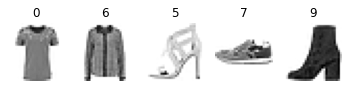

In [ ]:
for X, y in train_set.take(1):
    for i in range(5):
        plt.subplot(1, 5, i + 1)
        plt.imshow(X[i].numpy(), cmap="binary")
        plt.axis("off")
        plt.title(str(y[i].numpy()))

In [ ]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

class Standardization(keras.layers.Layer):
    def adapt(self, data_sample):
        self.means_ = np.mean(data_sample, axis=0, keepdims=True)
        self.stds_ = np.std(data_sample, axis=0, keepdims=True)
    def call(self, inputs):
        return (inputs - self.means_) / (self.stds_ + keras.backend.epsilon())

standardization = Standardization(input_shape=[28, 28])
# or perhaps soon:
#standardization = keras.layers.Normalization()

sample_image_batches = train_set.take(100).map(lambda image, label: image)
sample_images = np.concatenate(list(sample_image_batches.as_numpy_iterator()),
                               axis=0).astype(np.float32)
standardization.adapt(sample_images)

model = keras.models.Sequential([
    standardization,
    keras.layers.Flatten(),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="nadam", metrics=["accuracy"])

In [ ]:
from datetime import datetime
logs = os.path.join(os.curdir, "my_logs",
                    "run_" + datetime.now().strftime("%Y%m%d_%H%M%S"))

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=logs, histogram_freq=1, profile_batch=10)

model.fit(train_set, epochs=5, validation_data=valid_set,
          callbacks=[tensorboard_cb])

Epoch 1/5
1719/1719 [==============================] - 4s 2ms/step - loss: 656.6687 - accuracy: 0.8038 - val_loss: 82.8087 - val_accuracy: 0.8806
Epoch 2/5
1719/1719 [==============================] - 4s 2ms/step - loss: 209.0040 - accuracy: 0.8781 - val_loss: 147.8434 - val_accuracy: 0.8906
Epoch 3/5
1719/1719 [==============================] - 3s 2ms/step - loss: 146.5866 - accuracy: 0.8914 - val_loss: 361.5933 - val_accuracy: 0.9058
Epoch 4/5
1719/1719 [==============================] - 3s 2ms/step - loss: 110.8240 - accuracy: 0.9014 - val_loss: 150.4520 - val_accuracy: 0.9143
Epoch 5/5
1719/1719 [==============================] - 3s 2ms/step - loss: 175.6303 - accuracy: 0.9106 - val_loss: 42.5092 - val_accuracy: 0.9141


**Warning:** The profiling tab in TensorBoard works if you use TensorFlow 2.2+. You also need to make sure `tensorboard_plugin_profile` is installed (and restart Jupyter if necessary).

In [ ]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

## 10.
_Exercise: In this exercise you will download a dataset, split it, create a `tf.data.Dataset` to load it and preprocess it efficiently, then build and train a binary classification model containing an `Embedding` layer._

### a.
_Exercise: Download the [Large Movie Review Dataset](https://homl.info/imdb), which contains 50,000 movies reviews from the [Internet Movie Database](https://imdb.com/). The data is organized in two directories, `train` and `test`, each containing a `pos` subdirectory with 12,500 positive reviews and a `neg` subdirectory with 12,500 negative reviews. Each review is stored in a separate text file. There are other files and folders (including preprocessed bag-of-words), but we will ignore them in this exercise._

In [ ]:
from pathlib import Path

DOWNLOAD_ROOT = "http://ai.stanford.edu/~amaas/data/sentiment/"
FILENAME = "aclImdb_v1.tar.gz"
filepath = keras.utils.get_file(FILENAME, DOWNLOAD_ROOT + FILENAME, extract=True)
path = Path(filepath).parent / "aclImdb"
path

84131840/84125825 [==============================] - 12s 0us/step


PosixPath('/Users/ageron/.keras/datasets/aclImdb')

In [ ]:
for name, subdirs, files in os.walk(path):
    indent = len(Path(name).parts) - len(path.parts)
    print("    " * indent + Path(name).parts[-1] + os.sep)
    for index, filename in enumerate(sorted(files)):
        if index == 3:
            print("    " * (indent + 1) + "...")
            break
        print("    " * (indent + 1) + filename)

aclImdb/
    README
    imdb.vocab
    imdbEr.txt
    test/
        labeledBow.feat
        urls_neg.txt
        urls_pos.txt
        neg/
            0_2.txt
            10000_4.txt
            10001_1.txt
            ...
        pos/
            0_10.txt
            10000_7.txt
            10001_9.txt
            ...
    train/
        labeledBow.feat
        unsupBow.feat
        urls_neg.txt
        ...
        neg/
            0_3.txt
            10000_4.txt
            10001_4.txt
            ...
        unsup/
            0_0.txt
            10000_0.txt
            10001_0.txt
            ...
        pos/
            0_9.txt
            10000_8.txt
            10001_10.txt
            ...


In [ ]:
def review_paths(dirpath):
    return [str(path) for path in dirpath.glob("*.txt")]

train_pos = review_paths(path / "train" / "pos")
train_neg = review_paths(path / "train" / "neg")
test_valid_pos = review_paths(path / "test" / "pos")
test_valid_neg = review_paths(path / "test" / "neg")

len(train_pos), len(train_neg), len(test_valid_pos), len(test_valid_neg)

(12500, 12500, 12500, 12500)

### b.
_Exercise: Split the test set into a validation set (15,000) and a test set (10,000)._

In [ ]:
np.random.shuffle(test_valid_pos)

test_pos = test_valid_pos[:5000]
test_neg = test_valid_neg[:5000]
valid_pos = test_valid_pos[5000:]
valid_neg = test_valid_neg[5000:]

### c.
_Exercise: Use tf.data to create an efficient dataset for each set._

Since the dataset fits in memory, we can just load all the data using pure Python code and use `tf.data.Dataset.from_tensor_slices()`:

In [ ]:
def imdb_dataset(filepaths_positive, filepaths_negative):
    reviews = []
    labels = []
    for filepaths, label in ((filepaths_negative, 0), (filepaths_positive, 1)):
        for filepath in filepaths:
            with open(filepath) as review_file:
                reviews.append(review_file.read())
            labels.append(label)
    return tf.data.Dataset.from_tensor_slices(
        (tf.constant(reviews), tf.constant(labels)))

In [ ]:
for X, y in imdb_dataset(train_pos, train_neg).take(3):
    print(X)
    print(y)
    print()

tf.Tensor(b"Working with one of the best Shakespeare sources, this film manages to be creditable to it's source, whilst still appealing to a wider audience.<br /><br />Branagh steals the film from under Fishburne's nose, and there's a talented cast on good form.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int32)

tf.Tensor(b'Well...tremors I, the original started off in 1990 and i found the movie quite enjoyable to watch. however, they proceeded to make tremors II and III. Trust me, those movies started going downhill right after they finished the first one, i mean, ass blasters??? Now, only God himself is capable of answering the question "why in Gods name would they create another one of these dumpster dives of a movie?" Tremors IV cannot be considered a bad movie, in fact it cannot be even considered an epitome of a bad movie, for it lives up to more than that. As i attempted to sit though it, i noticed that my eyes started to bleed, and i hoped profusely that the little 

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

17.4 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


It takes about 17 seconds to load the dataset and go through it 10 times.

But let's pretend the dataset does not fit in memory, just to make things more interesting. Luckily, each review fits on just one line (they use `<br />` to indicate line breaks), so we can read the reviews using a `TextLineDataset`. If they didn't we would have to preprocess the input files (e.g., converting them to TFRecords). For very large datasets, it would make sense to use a tool like Apache Beam for that.

In [ ]:
def imdb_dataset(filepaths_positive, filepaths_negative, n_read_threads=5):
    dataset_neg = tf.data.TextLineDataset(filepaths_negative,
                                          num_parallel_reads=n_read_threads)
    dataset_neg = dataset_neg.map(lambda review: (review, 0))
    dataset_pos = tf.data.TextLineDataset(filepaths_positive,
                                          num_parallel_reads=n_read_threads)
    dataset_pos = dataset_pos.map(lambda review: (review, 1))
    return tf.data.Dataset.concatenate(dataset_pos, dataset_neg)

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).repeat(10): pass

33 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


Now it takes about 33 seconds to go through the dataset 10 times. That's much slower, essentially because the dataset is not cached in RAM, so it must be reloaded at each epoch. If you add `.cache()` just before `.repeat(10)`, you will see that this implementation will be about as fast as the previous one.

In [ ]:
%timeit -r1 for X, y in imdb_dataset(train_pos, train_neg).cache().repeat(10): pass

16.8 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
batch_size = 32

train_set = imdb_dataset(train_pos, train_neg).shuffle(25000).batch(batch_size).prefetch(1)
valid_set = imdb_dataset(valid_pos, valid_neg).batch(batch_size).prefetch(1)
test_set = imdb_dataset(test_pos, test_neg).batch(batch_size).prefetch(1)

### d.
_Exercise: Create a binary classification model, using a `TextVectorization` layer to preprocess each review. If the `TextVectorization` layer is not yet available (or if you like a challenge), try to create your own custom preprocessing layer: you can use the functions in the `tf.strings` package, for example `lower()` to make everything lowercase, `regex_replace()` to replace punctuation with spaces, and `split()` to split words on spaces. You should use a lookup table to output word indices, which must be prepared in the `adapt()` method._

Let's first write a function to preprocess the reviews, cropping them to 300 characters, converting them to lower case, then replacing `<br />` and all non-letter characters to spaces, splitting the reviews into words, and finally padding or cropping each review so it ends up with exactly `n_words` tokens:

In [ ]:
def preprocess(X_batch, n_words=50):
    shape = tf.shape(X_batch) * tf.constant([1, 0]) + tf.constant([0, n_words])
    Z = tf.strings.substr(X_batch, 0, 300)
    Z = tf.strings.lower(Z)
    Z = tf.strings.regex_replace(Z, b"<br\\s*/?>", b" ")
    Z = tf.strings.regex_replace(Z, b"[^a-z]", b" ")
    Z = tf.strings.split(Z)
    return Z.to_tensor(shape=shape, default_value=b"<pad>")

X_example = tf.constant(["It's a great, great movie! I loved it.", "It was terrible, run away!!!"])
preprocess(X_example)

<tf.Tensor: shape=(2, 50), dtype=string, numpy=
array([[b'it', b's', b'a', b'great', b'great', b'movie', b'i', b'loved',
        b'it', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>'],
       [b'it', b'was', b'terrible', b'run', b'away', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>',
        b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'<pad>', b'

Now let's write a second utility function that will take a data sample with the same format as the output of the `preprocess()` function, and will output the list of the top `max_size` most frequent words, ensuring that the padding token is first:

In [ ]:
from collections import Counter

def get_vocabulary(data_sample, max_size=1000):
    preprocessed_reviews = preprocess(data_sample).numpy()
    counter = Counter()
    for words in preprocessed_reviews:
        for word in words:
            if word != b"<pad>":
                counter[word] += 1
    return [b"<pad>"] + [word for word, count in counter.most_common(max_size)]

get_vocabulary(X_example)

[b'<pad>',
 b'it',
 b'great',
 b's',
 b'a',
 b'movie',
 b'i',
 b'loved',
 b'was',
 b'terrible',
 b'run',
 b'away']

Now we are ready to create the `TextVectorization` layer. Its constructor just saves the hyperparameters (`max_vocabulary_size` and `n_oov_buckets`). The `adapt()` method computes the vocabulary using the `get_vocabulary()` function, then it builds a `StaticVocabularyTable` (see Chapter 16 for more details). The `call()` method preprocesses the reviews to get a padded list of words for each review, then it uses the `StaticVocabularyTable` to lookup the index of each word in the vocabulary:

In [ ]:
class TextVectorization(keras.layers.Layer):
    def __init__(self, max_vocabulary_size=1000, n_oov_buckets=100, dtype=tf.string, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.max_vocabulary_size = max_vocabulary_size
        self.n_oov_buckets = n_oov_buckets

    def adapt(self, data_sample):
        self.vocab = get_vocabulary(data_sample, self.max_vocabulary_size)
        words = tf.constant(self.vocab)
        word_ids = tf.range(len(self.vocab), dtype=tf.int64)
        vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
        self.table = tf.lookup.StaticVocabularyTable(vocab_init, self.n_oov_buckets)
        
    def call(self, inputs):
        preprocessed_inputs = preprocess(inputs)
        return self.table.lookup(preprocessed_inputs)

Let's try it on our small `X_example` we defined earlier:

In [ ]:
text_vectorization = TextVectorization()

text_vectorization.adapt(X_example)
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[ 1,  3,  4,  2,  2,  5,  6,  7,  1,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0],
       [ 1,  8,  9, 10, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0,  0]])>

Looks good! As you can see, each review was cleaned up and tokenized, then each word was encoded as its index in the vocabulary (all the 0s correspond to the `<pad>` tokens).

Now let's create another `TextVectorization` layer and let's adapt it to the full IMDB training set (if the training set did not fit in RAM, we could just use a smaller sample of the training set by calling `train_set.take(500)`):

In [ ]:
max_vocabulary_size = 1000
n_oov_buckets = 100

sample_review_batches = train_set.map(lambda review, label: review)
sample_reviews = np.concatenate(list(sample_review_batches.as_numpy_iterator()),
                                axis=0)

text_vectorization = TextVectorization(max_vocabulary_size, n_oov_buckets,
                                       input_shape=[])
text_vectorization.adapt(sample_reviews)

Let's run it on the same `X_example`, just to make sure the word IDs are larger now, since the vocabulary is bigger:

In [ ]:
text_vectorization(X_example)

<tf.Tensor: shape=(2, 50), dtype=int64, numpy=
array([[  9,  14,   2,  64,  64,  12,   5, 257,   9,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  9,  13, 269, 531, 335,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0]])>

Good! Now let's take a look at the first 10 words in the vocabulary:

In [ ]:
text_vectorization.vocab[:10]

[b'<pad>', b'the', b'a', b'of', b'and', b'i', b'to', b'is', b'this', b'it']

These are the most common words in the reviews.

Now to build our model we will need to encode all these word IDs somehow. One approach is to create bags of words: for each review, and for each word in the vocabulary, we count the number of occurences of that word in the review. For example:

In [ ]:
simple_example = tf.constant([[1, 3, 1, 0, 0], [2, 2, 0, 0, 0]])
tf.reduce_sum(tf.one_hot(simple_example, 4), axis=1)

<tf.Tensor: shape=(2, 4), dtype=float32, numpy=
array([[2., 2., 0., 1.],
       [3., 0., 2., 0.]], dtype=float32)>

The first review has 2 times the word 0, 2 times the word 1, 0 times the word 2, and 1 time the word 3, so its bag-of-words representation is `[2, 2, 0, 1]`. Similarly, the second review has 3 times the word 0, 0 times the word 1, and so on. Let's wrap this logic in a small custom layer, and let's test it. We'll drop the counts for the word 0, since this corresponds to the `<pad>` token, which we don't care about.

In [ ]:
class BagOfWords(keras.layers.Layer):
    def __init__(self, n_tokens, dtype=tf.int32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self.n_tokens = n_tokens
    def call(self, inputs):
        one_hot = tf.one_hot(inputs, self.n_tokens)
        return tf.reduce_sum(one_hot, axis=1)[:, 1:]

Let's test it:

In [ ]:
bag_of_words = BagOfWords(n_tokens=4)
bag_of_words(simple_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[2., 0., 1.],
       [0., 2., 0.]], dtype=float32)>

It works fine! Now let's create another `BagOfWord` with the right vocabulary size for our training set:

In [ ]:
n_tokens = max_vocabulary_size + n_oov_buckets + 1 # add 1 for <pad>
bag_of_words = BagOfWords(n_tokens)

We're ready to train the model!

In [ ]:
model = keras.models.Sequential([
    text_vectorization,
    bag_of_words,
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])
model.compile(loss="binary_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 5s 5ms/step - loss: 0.5834 - accuracy: 0.6784 - val_loss: 0.5116 - val_accuracy: 0.7376
Epoch 2/5
782/782 [==============================] - 5s 5ms/step - loss: 0.4647 - accuracy: 0.7738 - val_loss: 0.4998 - val_accuracy: 0.7445
Epoch 3/5
782/782 [==============================] - 5s 5ms/step - loss: 0.4141 - accuracy: 0.8062 - val_loss: 0.5025 - val_accuracy: 0.7457
Epoch 4/5
782/782 [==============================] - 5s 5ms/step - loss: 0.3506 - accuracy: 0.8536 - val_loss: 0.5308 - val_accuracy: 0.7465
Epoch 5/5
782/782 [==============================] - 5s 5ms/step - loss: 0.2642 - accuracy: 0.9039 - val_loss: 0.5681 - val_accuracy: 0.7351


We get about 73.5% accuracy on the validation set after just the first epoch, but after that the model makes no significant progress. We will do better in Chapter 16. For now the point is just to perform efficient preprocessing using `tf.data` and Keras preprocessing layers.

### e.
_Exercise: Add an `Embedding` layer and compute the mean embedding for each review, multiplied by the square root of the number of words (see Chapter 16). This rescaled mean embedding can then be passed to the rest of your model._

To compute the mean embedding for each review, and multiply it by the square root of the number of words in that review, we will need a little function. For each sentence, this function needs to compute $M \times \sqrt N$, where $M$ is the mean of all the word embeddings in the sentence (excluding padding tokens), and $N$ is the number of words in the sentence (also excluding padding tokens). We can rewrite $M$ as $\dfrac{S}{N}$, where $S$ is the sum of all word embeddings (it does not matter whether or not we include the padding tokens in this sum, since their representation is a zero vector). So the function must return $M \times \sqrt N = \dfrac{S}{N} \times \sqrt N = \dfrac{S}{\sqrt N \times \sqrt N} \times \sqrt N= \dfrac{S}{\sqrt N}$.

In [ ]:
def compute_mean_embedding(inputs):
    not_pad = tf.math.count_nonzero(inputs, axis=-1)
    n_words = tf.math.count_nonzero(not_pad, axis=-1, keepdims=True)    
    sqrt_n_words = tf.math.sqrt(tf.cast(n_words, tf.float32))
    return tf.reduce_sum(inputs, axis=1) / sqrt_n_words

another_example = tf.constant([[[1., 2., 3.], [4., 5., 0.], [0., 0., 0.]],
                               [[6., 0., 0.], [0., 0., 0.], [0., 0., 0.]]])
compute_mean_embedding(another_example)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[3.535534 , 4.9497476, 2.1213205],
       [6.       , 0.       , 0.       ]], dtype=float32)>

Let's check that this is correct. The first review contains 2 words (the last token is a zero vector, which represents the `<pad>` token). Let's compute the mean embedding for these 2 words, and multiply the result by the square root of 2:

In [ ]:
tf.reduce_mean(another_example[0:1, :2], axis=1) * tf.sqrt(2.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[3.535534 , 4.9497476, 2.1213202]], dtype=float32)>

Looks good! Now let's check the second review, which contains just one word (we ignore the two padding tokens):

In [ ]:
tf.reduce_mean(another_example[1:2, :1], axis=1) * tf.sqrt(1.)

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[6., 0., 0.]], dtype=float32)>

Perfect. Now we're ready to train our final model. It's the same as before, except we replaced the `BagOfWords` layer with an `Embedding` layer followed by a `Lambda` layer that calls the `compute_mean_embedding` layer:

In [ ]:
embedding_size = 20

model = keras.models.Sequential([
    text_vectorization,
    keras.layers.Embedding(input_dim=n_tokens,
                           output_dim=embedding_size,
                           mask_zero=True), # <pad> tokens => zero vectors
    keras.layers.Lambda(compute_mean_embedding),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(1, activation="sigmoid"),
])

### f.
_Exercise: Train the model and see what accuracy you get. Try to optimize your pipelines to make training as fast as possible._

In [ ]:
model.compile(loss="binary_crossentropy", optimizer="nadam", metrics=["accuracy"])
model.fit(train_set, epochs=5, validation_data=valid_set)

Epoch 1/5
782/782 [==============================] - 3s 2ms/step - loss: 0.6053 - accuracy: 0.6568 - val_loss: 0.5151 - val_accuracy: 0.7382
Epoch 2/5
782/782 [==============================] - 2s 2ms/step - loss: 0.4922 - accuracy: 0.7569 - val_loss: 0.5081 - val_accuracy: 0.7466
Epoch 3/5
782/782 [==============================] - 2s 2ms/step - loss: 0.4827 - accuracy: 0.7628 - val_loss: 0.4978 - val_accuracy: 0.7473
Epoch 4/5
782/782 [==============================] - 2s 2ms/step - loss: 0.4761 - accuracy: 0.7656 - val_loss: 0.4959 - val_accuracy: 0.7513
Epoch 5/5
782/782 [==============================] - 3s 2ms/step - loss: 0.4737 - accuracy: 0.7687 - val_loss: 0.4978 - val_accuracy: 0.7471


The model is not better using embeddings (but we will do better in Chapter 16). The pipeline looks fast enough (we optimized it earlier).

### g.
_Exercise: Use TFDS to load the same dataset more easily: `tfds.load("imdb_reviews")`._

In [ ]:
import tensorflow_datasets as tfds

datasets = tfds.load(name="imdb_reviews")
train_set, test_set = datasets["train"], datasets["test"]

In [ ]:
for example in train_set.take(1):
    print(example["text"])
    print(example["label"])

tf.Tensor(b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.", shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)
